# **Project 02**

---
Author: Chen Siyi, Kim Minjung



# Import Packages


In [ ]:
pip install SimpleITK

     |████████████████████████████████| 48.4 MB 4.7 kB/s 


In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.6 kB/s 
     |████████████████████████████████| 8.8 MB 1.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu111
    Uninstalling torch-1.9.0+cu111:
      Successfully uninstalled torch-1.9.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu111
    Uninstalling torchvision-0.10.0+cu111:
      Successfully uninstalled torchvision-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.2.0+cu92 which is incompatible.


In [ ]:
import glob
import os 
from pathlib import Path
import random

from PIL import Image
import numpy as np
import pandas  as pd
import nibabel as nib
import matplotlib.pyplot as plt

import SimpleITK as sitk

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets,transforms, models
import torchvision.transforms.functional as TF

In [ ]:
!pip install -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 102 kB 5.2 MB/s 
     |████████████████████████████████| 47.6 MB 35 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets,transforms, models
import torchvision.transforms.functional as TF

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib #for loading nii files
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf #for deep learning
import os
from nibabel.testing import data_path

In [ ]:
import ipywidgets

# Load and Read Data
1.   sitk.ReadImage
2.   sitk.GetArrayFromImage



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = Path('drive/MyDrive/E_Lungs')

**need to import old version SimpleITK like 2.0.2**

> otherwise appear error in ReadImage: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/NIFTI/src/itkNiftiImageIO.cxx:1980:ITK ERROR: ITK only supports orthonormal direction cosines.  No orthonormal definition found!

https://discourse.aicrowd.com/t/simpleitk-versions-problems/6384/3

actually find wrong, I use nib to replace it

In [ ]:
def read_nii(filepath, sl=None):
    '''
    Reads .nii volume file and returns pixel array for slice sl
    '''
    sample_ct = nib.load(str(filepath))
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    if sl != None:
        array = sample_ct.dataobj[:,:,sl]
        array = np.rot90(array)
    else:
        array = sample_ct.dataobj
        array = np.rot90(array)
    return(array)    


# def read_nii(filepath, sl=None):
#     '''
#     Reads .nii volume file and returns pixel array for slice sl
#     '''
#     sample_ct = sitk.ReadImage(str(filepath))
#     # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
#     if sl != None:
#         array = sitk.GetArrayFromImage(sitk.Tile(sample_ct[:, :, sl], (1, 2, 0)))
#     else:
#         array = sitk.GetArrayFromImage(sitk.Tile(sample_ct)).transpose((1,2,0))
#     return(array)    

# Data List

1.   python's enumerate: https://realpython.com/python-enumerate/
2.   scikit-learn's train_test_split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
*   20% as test data
*   10% as validation data
*   70% as train data
2.   random.choices: choose k data randomly

In [ ]:
def read_slices(all_data):
    '''
    Reads the slices and creates a list of tuples, containing one row per slice in the format [image, mask, slice number]
    '''
    filename_slices = []
    for idx, fn_data in enumerate(all_data):
        fn_mask = Path(str(fn_data).replace('org_', ''))
        fn_mask = Path(str(fn_mask).replace('covid-19-pneumonia-', ''))
        fn_mask = Path(str(fn_mask).replace('-dcm', ''))
        fn_lung_mask = Path(str(fn_mask).replace('ct_scans', 'lung_mask'))
        fn_infection_mask = Path(str(fn_mask).replace('ct_scans', 'infection_mask'))
        data = read_nii(fn_lung_mask)
        for sl in range(data.shape[2]):
            if np.sum(data[:,:,sl]) > 5000:
                filename_slices += [(fn_data, fn_lung_mask, fn_infection_mask, sl)]
    return filename_slices

In [ ]:
#
#  Get the list of all the masks
#

# filenames_mask = list(data_dir.glob('ct_scans/coronacases*.nii'))
filenames_mask = list(data_dir.glob('ct_scans/*.nii'))
print(f'Total number of masks: {len(filenames_mask)}')

#
# Split into the training, validation and test splits using scikit-learn's train_test_split function. 
# Also, check to see how many are in each to make sure that it makes sense.
#

# tt, test_filenames = train_test_split(filenames_mask, test_size = 0.2)
# train_filenames, val_filenames = train_test_split(tt, test_size = 0.2) #we split the temporary variables in an 80/20 partition

tt, test_filenames = train_test_split(filenames_mask, test_size = 0.2)
train_filenames, val_filenames = train_test_split(tt, test_size = 0.125) 

print(f'Number of training data: {len(train_filenames)}')
print(f'Number of validation data: {len(val_filenames)}')
print(f'Number of test data: {len(test_filenames)}')

Total number of masks: 20
Number of training data: 14
Number of validation data: 2
Number of test data: 4


In [ ]:
train_file_slices = read_slices(train_filenames)
val_file_slices = read_slices(val_filenames)
test_file_slices = read_slices(test_filenames)

print(f'Number of training slices: {len(train_file_slices)}')
print(f'Number of validation slices: {len(val_file_slices)}')
print(f'Number of test slices: {len(test_file_slices)}')

print(f'First few training items: ')
for tfs in train_file_slices[:3]:
    print(tfs)

Number of training slices: 1717
Number of validation slices: 380
Number of test slices: 642
First few training items: 
(PosixPath('drive/MyDrive/E_Lungs/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/radiopaedia_10_85902_1.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/radiopaedia_10_85902_1.nii'), 5)
(PosixPath('drive/MyDrive/E_Lungs/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/radiopaedia_10_85902_1.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/radiopaedia_10_85902_1.nii'), 6)
(PosixPath('drive/MyDrive/E_Lungs/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/radiopaedia_10_85902_1.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/radiopaedia_10_85902_1.nii'), 7)


In [ ]:
train_file_slices = random.choices(train_file_slices,k=500)
val_file_slices = random.choices(val_file_slices, k=50)
test_file_slices = random.choices(test_file_slices, k=100)

# Display Image

(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_003.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_003.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_003.nii'), 50)


Text(0.5, 1.0, 'Infection Mask')

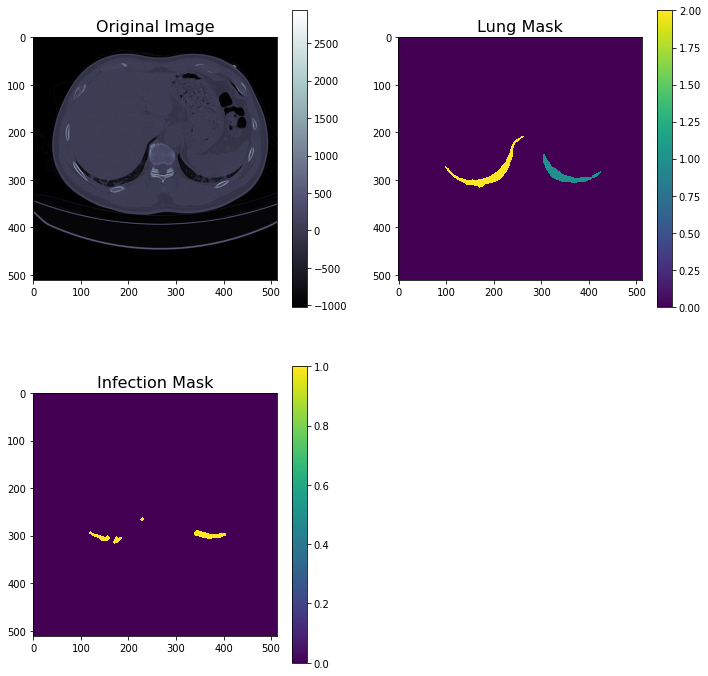

In [ ]:
# Get the filenames and slice from the structure
fn, fn_lung_mask, fn_infection_mask, sl = train_file_slices[0]
print(f'{train_file_slices[0]}')

# Load the data using the loading function that will be used later
sample_ct = read_nii(fn, sl)
sample_lung_mask = read_nii(fn_lung_mask, sl)
sample_infection_mask = read_nii(fn_infection_mask, sl)

# Plot the data, and make it look nice, you will probably use this in a paper
fig = plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
plt.imshow(sample_ct, cmap='bone')
plt.colorbar()
plt.title('Original Image', fontsize=16)
plt.subplot(2,2,2)
plt.imshow(sample_lung_mask, interpolation='none')
plt.colorbar()
plt.title('Lung Mask', fontsize=16)
plt.subplot(2,2,3)
plt.imshow(sample_infection_mask, interpolation='none')
plt.colorbar()
plt.title('Infection Mask', fontsize=16)

# **Image Intensity-Based (Threshold) Segmentation**

---



In [ ]:
def imstrip(images, **imshow_args):
    """View multiple images side by side."""
    import numpy as np
    from matplotlib import pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure(figsize=[5*len(images),4])
    axs = ImageGrid(fig, 111, nrows_ncols=[1,len(images)], axes_pad=0.9, cbar_mode='each', cbar_pad=0.1)
    for i, image in enumerate(images):
        kwargs = imshow_args.copy()
        kwargs.setdefault('cmap', 'gray')
        kwargs.setdefault('clim', np.percentile(np.array(image, dtype=np.float32), [1,99]))
        im = axs[i].imshow(image, **kwargs)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        fig.colorbar(im, cax=axs.cbar_axes[i])
    return axs

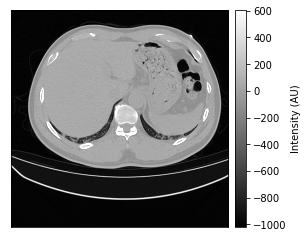

In [ ]:
axs = imstrip([sample_ct])
axs[0].images[0].colorbar.set_label('Intensity (AU)')

In [ ]:
@ipywidgets.interact(threshold=(sample_ct.min(), sample_ct.max()))
def threshold(threshold=np.percentile(sample_ct, 75)):
    thresholded = sample_ct < threshold
    fig, axs = plt.subplots(ncols=2, figsize=[9,4])

    # left axis
    axs[0].hist(np.ravel(sample_ct), bins=50)
    axs[0].axvline(threshold, color='C1')
    axs[0].set_xlabel('Intensity')
    axs[0].set_ylabel('Count')

    # right axis
    im = axs[1].imshow(thresholded, cmap='gray')
    axs[1].set_xticks([])
    axs[1].set_yticks([])


interactive(children=(IntSlider(value=34, description='threshold', max=2937, min=-1023), Output()), _dom_class…

In [ ]:
fn, fn_lung_mask, fn_infection_mask, sl = val_file_slices[5]
print(f'{val_file_slices[5]}')
print(sl)
sample_ct = read_nii(fn, sl)
sample_lung_mask = read_nii(fn_lung_mask, sl)
sample_infection_mask = read_nii(fn_infection_mask, sl)

(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_008.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_008.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_008.nii'), 90)
90


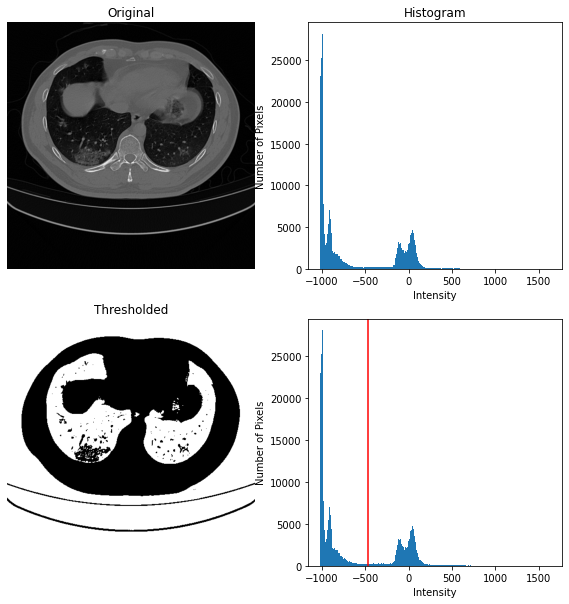

In [ ]:
from skimage.filters import threshold_minimum


image = sample_ct

thresh_min = threshold_minimum(image)
binary_min = image < thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')
ax[0, 1].set_xlabel('Intensity')
ax[0, 1].set_ylabel('Number of Pixels')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')
ax[1, 1].set_xlabel('Intensity')
ax[1, 1].set_ylabel('Number of Pixels')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

Text(0.5, 1.0, 'Sample Infection Mask')

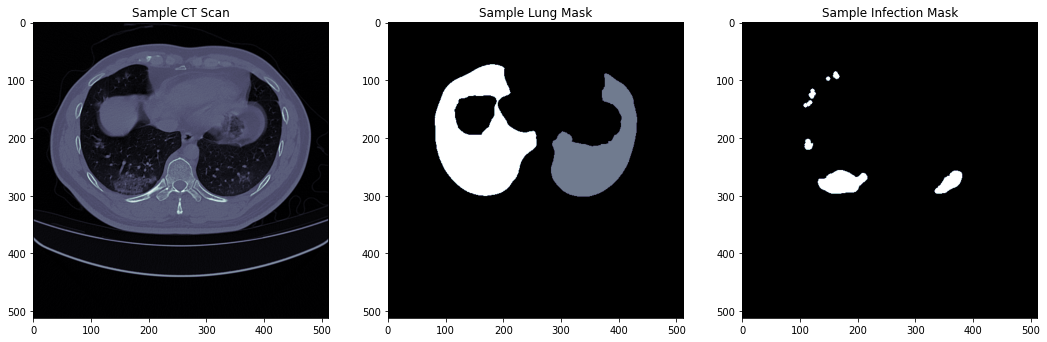

In [ ]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,3,1)
plt.imshow(sample_ct, cmap = 'bone')
plt.title('Sample CT Scan')

plt.subplot(1,3,2)
plt.imshow(sample_lung_mask,cmap = 'bone')
plt.title('Sample Lung Mask')

plt.subplot(1,3,3)
plt.imshow(sample_infection_mask,cmap = 'bone')
plt.title('Sample Infection Mask')

In [ ]:
# image segmentation
from skimage.morphology import binary_erosion, binary_dilation, disk
from scipy.ndimage import generate_binary_structure
from skimage.morphology import label
from skimage.measure import regionprops
from scipy.ndimage.morphology import binary_fill_holes
from skimage.segmentation import clear_border
from skimage.segmentation import watershed

def largest_connected_component(image, connectivity=2):
    """Label image and return label with largest area."""
    labels = label(image)
    props = regionprops(labels)
    indices = np.argsort([prop.area for prop in props]) + 1
    return labels == indices[-1]

def strip_skull(image, threshold=-500, dilation=4):
    """Threshold-based skull stripping."""
    bone_tissue = image < threshold
    cranium = largest_connected_component(bone_tissue)  # defined above
    cranium_plus = binary_dilation(cranium, disk(dilation))
    brain = image.copy()
    brain[cranium_plus == 1] = brain.min()
    return brain

def second_largest_connected_component(image, connectivity=2):
    """Label image and return label with largest area."""
    labels = label(image)
    props = regionprops(labels)
    indices = np.argsort([prop.area for prop in props]) + 1
    return labels == indices[-2]


In [ ]:
def dice_coef(y_true, y_pred):
    """
    Compute the Dice coefficient between two N-D masks.
    """

    # Convert the input to a numpy array if it is a torch Tensor
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().detach().numpy()
    
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().detach().numpy()
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_006.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_006.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_006.nii'), 170)
170
1.4540004334174765


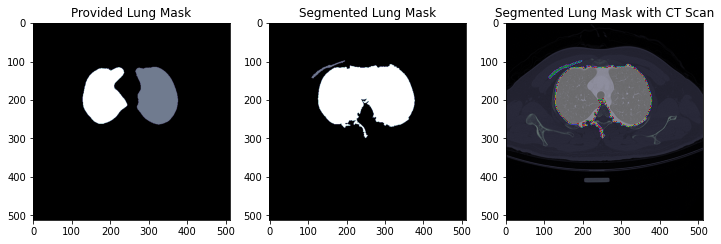

In [ ]:
fn, fn_lung_mask, fn_infection_mask, sl = train_file_slices[0]
print(f'{train_file_slices[0]}')
print(sl)
sample_ct = read_nii(fn, sl)
sample_lung_mask = read_nii(fn_lung_mask, sl)
sample_infection_mask = read_nii(fn_infection_mask, sl)
struct = generate_binary_structure(2, 1)
thresholded = strip_skull(sample_ct) < -50 
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total = lung_dilate1 + lung_dilate2
fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.imshow(sample_lung_mask, cmap = 'bone')
plt.title('Provided Lung Mask')

plt.subplot(1,3,2)
plt.imshow(lung_total, cmap = 'bone')
plt.title('Segmented Lung Mask')

plt.subplot(1,3,3)
plt.imshow(sample_ct, cmap = 'bone')
plt.imshow(lung_total,alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Segmented Lung Mask with CT Scan')

print(dice_coef(sample_lung_mask,lung_total))

(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_004.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_004.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_004.nii'), 19)
19
1.7200261341807102


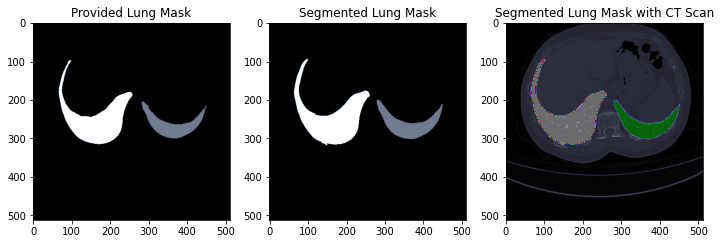

In [ ]:
# Get the filenames and slice from the structure
fn, fn_lung_mask, fn_infection_mask, sl = train_file_slices[2]
print(f'{train_file_slices[2]}')
print(sl)
# Load the data using the loading function that will be used later
sample_ct = read_nii(fn, sl)
sample_lung_mask = read_nii(fn_lung_mask, sl)
sample_infection_mask = read_nii(fn_infection_mask, sl)
struct = generate_binary_structure(2, 1)
thresholded = strip_skull(sample_ct) < -150 
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total = lung_dilate1 + lung_dilate2

fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.imshow(sample_lung_mask, cmap = 'bone')
plt.title('Provided Lung Mask')

plt.subplot(1,3,2)
plt.imshow(lung_total, cmap = 'bone')
plt.title('Segmented Lung Mask')

plt.subplot(1,3,3)
plt.imshow(sample_ct, cmap = 'bone')
plt.imshow(lung_total,alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Segmented Lung Mask with CT Scan')

print(dice_coef(sample_lung_mask,lung_total))

0.93850780981334


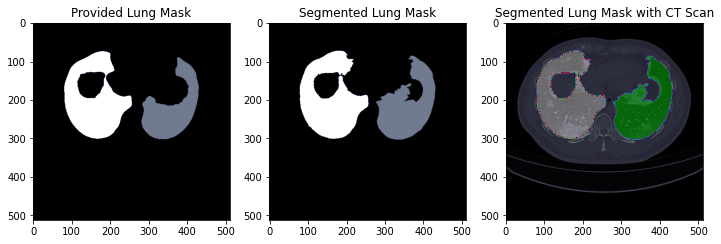

In [ ]:
# Get the filenames and slice from the structure
# fn, fn_lung_mask, fn_infection_mask, sl = val_file_slices[5]
# print(f'{train_file_slices[5]}')
# print(sl)
# Load the data using the loading function that will be used later
# sample_ct = read_nii(fn, sl)
# sample_lung_mask = read_nii(fn_lung_mask, sl)
# sample_infection_mask = read_nii(fn_infection_mask, sl)


sample_ct = read_nii('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_008.nii', 90)
sample_lung_mask = read_nii('drive/MyDrive/E_Lungs/lung_mask/coronacases_008.nii', 90)


struct = generate_binary_structure(2, 1)
thresholded = strip_skull(sample_ct) < -160 # (sample_ct > -191)
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total = lung_dilate1 + lung_dilate2

fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.imshow(sample_lung_mask, cmap = 'bone')
plt.title('Provided Lung Mask')

plt.subplot(1,3,2)
plt.imshow(lung_total, cmap = 'bone')
plt.title('Segmented Lung Mask')

plt.subplot(1,3,3)
plt.imshow(sample_ct, cmap = 'bone')
plt.imshow(lung_total,alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Segmented Lung Mask with CT Scan')
sample_lung_mask = sample_lung_mask.astype(bool)
lung_total = lung_total.astype(bool)
print(dice_coef(sample_lung_mask,lung_total))

DICE Score

In [ ]:
np.min(sample_ct)

-1021

(PosixPath('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_006.nii'), PosixPath('drive/MyDrive/E_Lungs/lung_mask/coronacases_006.nii'), PosixPath('drive/MyDrive/E_Lungs/infection_mask/coronacases_006.nii'), 170)
65
1.3659583593776383
-50
1.3659583593776383


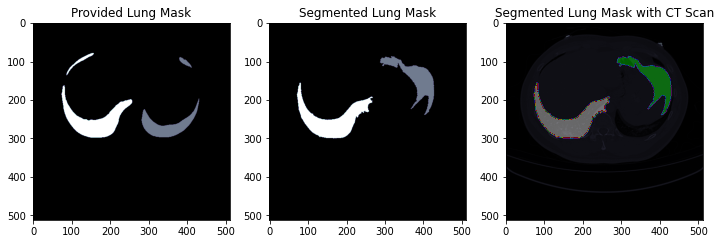

In [ ]:
fn, fn_lung_mask, fn_infection_mask, sl = val_file_slices[0]
print(f'{train_file_slices[0]}')
print(sl)
# Load the data using the loading function that will be used later
sample_ct = read_nii(fn, sl)
sample_lung_mask = read_nii(fn_lung_mask, sl)
sample_infection_mask = read_nii(fn_infection_mask, sl)
struct = generate_binary_structure(2, 1)
i = 0
temp = 0
dice_array = []
max_dice = -1000
s_thres = 0
for thres_num in range(-50,0):
  thresholded = strip_skull(sample_ct) < thres_num 
  lungs = clear_border(thresholded)
  largest = largest_connected_component(lungs)
  largest_2 = second_largest_connected_component(lungs)
  largest = largest*2
  larges = largest + largest_2
  lung_dilate1 = binary_dilation(largest,struct)
  lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
  lung_dilate1 = lung_dilate1 * 2

  lung_dilate2 = binary_dilation(largest_2,struct)
  lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
  lung_total = lung_dilate1 + lung_dilate2
  sample_lung_mask = sample_lung_mask.astype(bool)
  lung_total = lung_total.astype(bool)
  new_dice = dice_coef(sample_lung_mask,lung_total)
  if max_dice < new_dice:
    max_dice = new_dice
    s_thres = thres_num
print(max_dice)
print(s_thres)
thresholded = strip_skull(sample_ct) < s_thres 
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total = lung_dilate1 + lung_dilate2
fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.imshow(sample_lung_mask, cmap = 'bone')
plt.title('Provided Lung Mask')

plt.subplot(1,3,2)
plt.imshow(lung_total, cmap = 'bone')
plt.title('Segmented Lung Mask')

plt.subplot(1,3,3)
plt.imshow(sample_ct, cmap = 'bone')
plt.imshow(lung_total,alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Segmented Lung Mask with CT Scan')
sample_lung_mask = sample_lung_mask.astype(bool)
lung_total = lung_total.astype(bool)
print(dice_coef(sample_lung_mask,lung_total))

0.9741680467390719


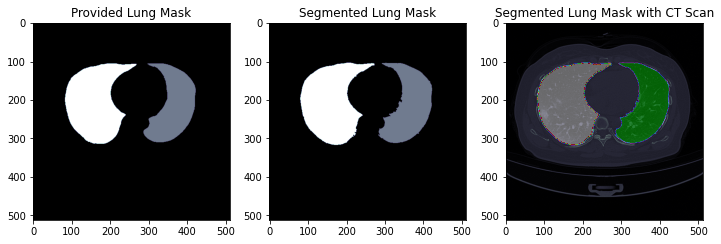

In [ ]:
sample_ct = read_nii('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_007.nii', 91)
sample_lung_mask = read_nii('drive/MyDrive/E_Lungs/lung_mask/coronacases_007.nii', 91)

struct = generate_binary_structure(2, 1)
max_dice = -1000
s_thres = 0

thresholded = strip_skull(sample_ct) < -160 
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total = lung_dilate1 + lung_dilate2
fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.imshow(sample_lung_mask, cmap = 'bone')
plt.title('Provided Lung Mask')

plt.subplot(1,3,2)
plt.imshow(lung_total, cmap = 'bone')
plt.title('Segmented Lung Mask')

plt.subplot(1,3,3)
plt.imshow(sample_ct, cmap = 'bone')
plt.imshow(lung_total,alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Segmented Lung Mask with CT Scan')
sample_lung_mask = sample_lung_mask.astype(bool)
lung_total = lung_total.astype(bool)
print(dice_coef(sample_lung_mask,lung_total))

0.9724298201964378
-329
0.9724298201964378


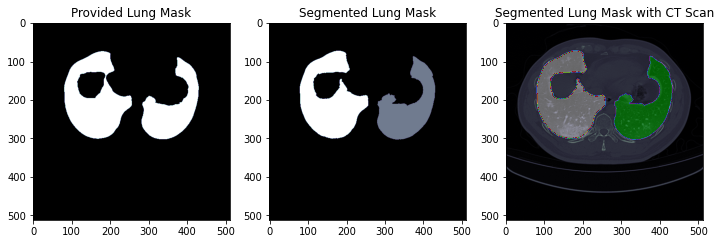

In [ ]:
sample_ct = read_nii('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_008.nii', 90)
sample_lung_mask = read_nii('drive/MyDrive/E_Lungs/lung_mask/coronacases_008.nii', 90)

struct = generate_binary_structure(2, 1)
i = 0
temp = 0
# thres_num = -100 # initial threshold number, start from a number that is not good
dice_array = []
max_dice = -1000
s_thres = 0
for thres_num in range(-500,-200):
  thresholded = strip_skull(sample_ct) < thres_num # (sample_ct > -191)
  lungs = clear_border(thresholded)
  largest = largest_connected_component(lungs)
  largest_2 = second_largest_connected_component(lungs)
  largest = largest*2
  larges = largest + largest_2
  lung_dilate1 = binary_dilation(largest,struct)
  lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
  lung_dilate1 = lung_dilate1 * 2

  lung_dilate2 = binary_dilation(largest_2,struct)
  lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
  lung_total = lung_dilate1 + lung_dilate2
  sample_lung_mask = sample_lung_mask.astype(bool)
  lung_total = lung_total.astype(bool)
  new_dice = dice_coef(sample_lung_mask,lung_total)
  tuplething = [thres_num, new_dice]
  dice_array.append(tuplething)
  if max_dice < new_dice:
    max_dice = new_dice
    s_thres = thres_num
print(max_dice)
print(s_thres)
thresholded = strip_skull(sample_ct) < s_thres 
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total = lung_dilate1 + lung_dilate2
fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.imshow(sample_lung_mask, cmap = 'bone')
plt.title('Provided Lung Mask')

plt.subplot(1,3,2)
plt.imshow(lung_total, cmap = 'bone')
plt.title('Segmented Lung Mask')

plt.subplot(1,3,3)
plt.imshow(sample_ct, cmap = 'bone')
plt.imshow(lung_total,alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Segmented Lung Mask with CT Scan')

sample_lung_mask = sample_lung_mask.astype(bool)
lung_total = lung_total.astype(bool)
print(dice_coef(sample_lung_mask,lung_total))
dice_array = np.asarray(dice_array)

No handles with labels found to put in legend.


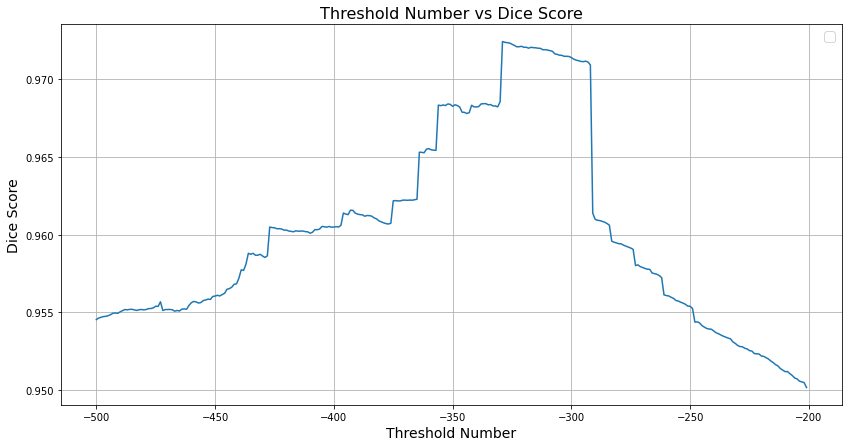

In [ ]:
fig = plt.figure(figsize=(14, 7))
plt.plot(dice_array[:,0],dice_array[:,1])
plt.xlabel('Threshold Number', fontsize=14)
plt.ylabel('Dice Score', fontsize=14)
plt.title('Threshold Number vs Dice Score', fontsize=16)
# plt.xticks(range(thres_num))
plt.grid('on')
plt.legend(fontsize=14)


0.7553432323134975
0.947090685800912
0.7268962960566264


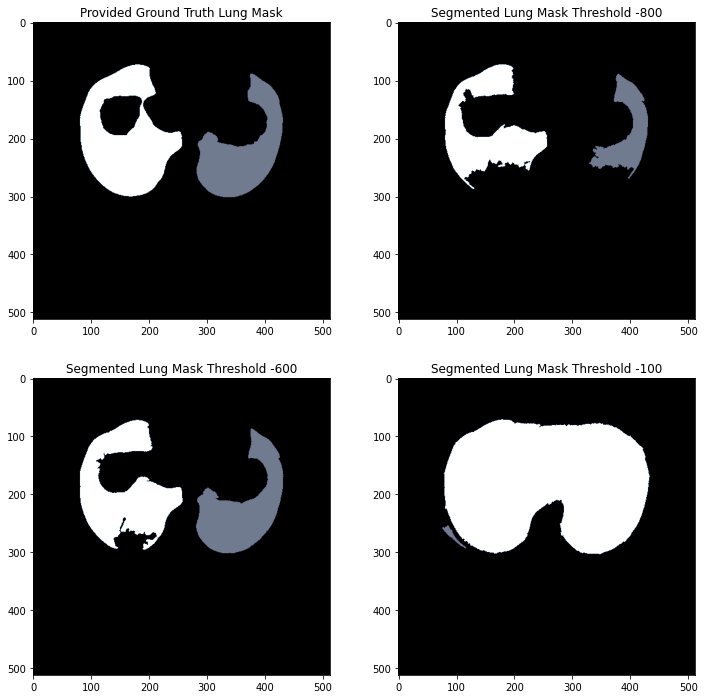

In [ ]:
sample_ct = read_nii('drive/MyDrive/E_Lungs/ct_scans/coronacases_org_008.nii', 90)
sample_lung_mask = read_nii('drive/MyDrive/E_Lungs/lung_mask/coronacases_008.nii', 90)

struct = generate_binary_structure(2, 1)
thresholded = strip_skull(sample_ct) < -800
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total550 = lung_dilate1 + lung_dilate2

thresholded = strip_skull(sample_ct) < -600
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total350 = lung_dilate1 + lung_dilate2

thresholded = strip_skull(sample_ct) < -100
lungs = clear_border(thresholded)
largest = largest_connected_component(lungs)
largest_2 = second_largest_connected_component(lungs)
largest = largest*2
larges = largest + largest_2
lung_dilate1 = binary_dilation(largest,struct)
lung_dilate1 = binary_fill_holes(lung_dilate1,struct)
lung_dilate1 = lung_dilate1 * 2

lung_dilate2 = binary_dilation(largest_2,struct)
lung_dilate2 = binary_fill_holes(lung_dilate2,struct)
lung_total150 = lung_dilate1 + lung_dilate2

fig = plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
plt.imshow(sample_lung_mask, cmap = 'bone')
plt.title('Provided Ground Truth Lung Mask')

plt.subplot(2,2,2)
plt.imshow(lung_total550, cmap = 'bone')
plt.title('Segmented Lung Mask Threshold -800')

plt.subplot(2,2,3)
plt.imshow(lung_total350, cmap = 'bone')
plt.title('Segmented Lung Mask Threshold -600')

plt.subplot(2,2,4)
plt.imshow(lung_total150, cmap = 'bone')
plt.title('Segmented Lung Mask Threshold -100')

sample_lung_mask = sample_lung_mask.astype(bool)
lung_total550 = lung_total550.astype(bool)
lung_total350 = lung_total350.astype(bool)
lung_total150 = lung_total150.astype(bool)

print(dice_coef(sample_lung_mask,lung_total550))
print(dice_coef(sample_lung_mask,lung_total350))
print(dice_coef(sample_lung_mask,lung_total150))

# **Neural Network Segmentation**

---



# Set Hyper Parameters

In [ ]:
batch_size = 8
epochs = 10

# GPU Setup

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Device is {device}')

if device == 'cuda':
    print(f'CUDA device {torch.cuda.device(0)}')
    print(f'Number of devices: {torch.cuda.device_count()}')
    print(f'Device name: {torch.cuda.get_device_name(0)}')

# Transformation and Data Augmentation


1.   albumentations: https://albumentations.ai/
2.   from albumentations.pytorch import ToTensorV2


In [ ]:
#
# Transformtions to be applied to the training set - This is using Albumentations
#

train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.Resize(128, 128),
        ToTensorV2(),
    ]
)

In [ ]:
#
# Transformtions to be applied to the validation and testing sets - this is using Albumentations
#

test_transform = A.Compose(
    [
        A.Resize(256, 256), 
        ToTensorV2()]
)

# Dataset and Data Loader

In [ ]:
#
# Create the Dataset class specific for this work.
# pytorch

class LungDataset(Dataset):
    
    def __init__(self, filename_slices, transform):
        """
        Initialized
        """
        super().__init__()

        # Store variables we are interested in...
        self._filename_slices = filename_slices 
        self._transform = transform    

    def __getitem__(self, index):

        """
        Get a single image / label pair.
        """
        #
        # Read in the image
        #

        fn, fn_lung_mask, fn_infection_mask, sl = self._filename_slices[index]
        
        image = read_nii(fn, sl)
        mm , MM = np.min(image), np.max(image)
        image = (image - mm) / (MM - mm) * 255 #Ensure input is between 0-255
        image = np.array(image, dtype=np.float32)
        
        #
        # Read in the lung mask
        #
        # lung_mask = read_nii(fn_lung_mask, sl).astype(np.int8)
        lung_mask = read_nii(fn_lung_mask, sl)/2;
        lung_mask = lung_mask.astype(np.float32) 
        #
        # Data augmentation 
        #
        if self._transform is not None:
            augmented = self._transform(image=image, mask=lung_mask)
            image = augmented['image']
            lung_mask = augmented['mask']
        
        #
        # Return the image mask pair
        #
        return image, lung_mask
    
    def __len__(self):
        """
        Return length of the dataset
        """
        return len(self._filename_slices)

class InfectionDataset(Dataset):
    
    def __init__(self, filename_slices, transform):
        """
        Initialized
        """
        super().__init__()

        # Store variables we are interested in...
        self._filename_slices = filename_slices 
        self._transform = transform    

    def __getitem__(self, index):

        """
        Get a single image / label pair.
        """
        #
        # Read in the image
        #

        fn, fn_lung_mask, fn_infection_mask, sl = self._filename_slices[index]
        
        image = read_nii(fn, sl)
        mm , MM = np.min(image), np.max(image)
        image = (image - mm) / (MM - mm) * 255 #Ensure input is between 0-255
        image = np.array(image, dtype=np.float32)
      

        #
        # Read in the infection mask
        #
        infection_mask = read_nii(fn_infection_mask, sl).astype(np.int8)

        #
        # Data augmentation 
        #
        if self._transform is not None:
            augmented = self._transform(image=image, mask=infection_mask)
            image = augmented['image']
            infection_mask = augmented['mask']
               
        #
        # Return the image mask pair
        #
        return image, infection_mask
    
    def __len__(self):
        """
        Return length of the dataset
        """
        return len(self._filename_slices)

In [ ]:
# Create the datsets and dataloaders for every subset 

train_Lung_dataset = LungDataset(train_file_slices, train_transform)
train_Infection_dataset = InfectionDataset(train_file_slices, train_transform)

train_Lung_dataloader = DataLoader(train_Lung_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 
train_Infection_dataloader = DataLoader(train_Infection_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 

val_Lung_dataset = LungDataset(val_file_slices, test_transform)
val_Infection_dataset = InfectionDataset(val_file_slices, test_transform)

val_Lung_dataloader = DataLoader(val_Lung_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 
val_Infection_dataloader = DataLoader(val_Infection_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 

test_Lung_dataset = LungDataset(test_file_slices, test_transform)
test_Infection_dataset = InfectionDataset(test_file_slices, test_transform)

test_Lung_dataloader = DataLoader(test_Lung_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 
test_Infection_dataloader = DataLoader(test_Infection_dataset, batch_size=batch_size, num_workers=0, shuffle=True) 

# Dataloader Visualization


1.   iter and next: https://www.programiz.com/python-programming/methods/built-in/iter



In [ ]:
image1, lung_mask = next(iter(train_Lung_dataloader))
image2, infection_mask = next(iter(train_Infection_dataloader))

fig = plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(image1[1,0])
plt.title('Input Image', fontsize=16)
plt.gray()
plt.subplot(2,2,2)
plt.imshow(lung_mask[1])
plt.title('Lung_Mask', fontsize=16)
plt.subplot(2,2,3)
plt.imshow(image2[1,0])
plt.title('Input Image', fontsize=16)
plt.gray()
plt.subplot(2,2,4)
plt.imshow(infection_mask[1])
plt.title('Infection_Mask', fontsize=16)

# U-Net Architecture

In [ ]:
class contracting(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())

        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.ReLU())

        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, stride=1, padding=1), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(256, 512, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(512, 512, 3, stride=1, padding=1), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(512, 1024, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(1024, 1024, 3, stride=1, padding=1), nn.ReLU())

        self.down_sample = nn.MaxPool2d(2, stride=2)


    def forward(self, X):
        X1 = self.layer1(X)
        X2 = self.layer2(self.down_sample(X1))
        X3 = self.layer3(self.down_sample(X2))
        X4 = self.layer4(self.down_sample(X3))
        X5 = self.layer5(self.down_sample(X4))
        return X5, X4, X3, X2, X1


class expansive(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Conv2d(64, 2, 3, stride=1, padding=1)

        self.layer2 = nn.Sequential(nn.Conv2d(128, 64, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU())

        self.layer3 = nn.Sequential(nn.Conv2d(256, 128, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.ReLU())

        self.layer4 = nn.Sequential(nn.Conv2d(512, 256, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(256, 256, 3, stride=1, padding=1), nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(1024, 512, 3, stride=1, padding=1), nn.ReLU(), nn.Conv2d(512, 512, 3, stride=1, padding=1), nn.ReLU())

        self.up_sample_54 = nn.ConvTranspose2d(1024, 512, 2, stride=2)

        self.up_sample_43 = nn.ConvTranspose2d(512, 256, 2, stride=2)

        self.up_sample_32 = nn.ConvTranspose2d(256, 128, 2, stride=2)

        self.up_sample_21 = nn.ConvTranspose2d(128, 64, 2, stride=2)


    def forward(self, X5, X4, X3, X2, X1):
        X = self.up_sample_54(X5)
        X4 = torch.cat([X, X4], dim=1)
        X4 = self.layer5(X4)

        X = self.up_sample_43(X4)
        X3 = torch.cat([X, X3], dim=1)
        X3 = self.layer4(X3)

        X = self.up_sample_32(X3)
        X2 = torch.cat([X, X2], dim=1)
        X2 = self.layer3(X2)

        X = self.up_sample_21(X2)
        X1 = torch.cat([X, X1], dim=1)
        X1 = self.layer2(X1)

        X = self.layer1(X1)

        return X


class unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.down = contracting()
        
        # Decoder
        self.up = expansive()

    def forward(self, X):
        # Encoder
        X5, X4, X3, X2, X1 = self.down(X)
        
        # Decoder
        X = self.up(X5, X4, X3, X2, X1)
        return X
        #F.softmax(X, dim=1)
    

# Train the Neural Network (Lung Mask)


In [ ]:
#
# Load the model
#

model = unet()
model.to(device)

#
# Create the optimizer
#
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#
# Create the loss function
#
loss = torch.nn.CrossEntropyLoss()

In [ ]:
def dice_coef(y_true, y_pred):
    """
    Compute the Dice coefficient between two N-D masks.
    """

    # Convert the input to a numpy array if it is a torch Tensor
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().detach().numpy()
    
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().detach().numpy()
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Training (Lung Mask)

Epoch 0 / 10
	Batch 0 loss 0.597
	Batch 1 loss 0.539
	Batch 2 loss 0.475
	Batch 3 loss 0.551
	Batch 4 loss 0.492
	Batch 5 loss 0.464
	Batch 6 loss 0.482
	Batch 7 loss 0.537
	Batch 8 loss 0.525
	Batch 9 loss 0.479
	Batch 10 loss 0.447
	Batch 11 loss 0.439
	Batch 12 loss 0.471
	Batch 13 loss 0.464
	Batch 14 loss 0.484
	Batch 15 loss 0.450
	Batch 16 loss 0.403
	Batch 17 loss 0.442
	Batch 18 loss 0.462
	Batch 19 loss 0.435
	Batch 20 loss 0.450
	Batch 21 loss 0.375
	Batch 22 loss 0.377
	Batch 23 loss 0.427
	Batch 24 loss 0.380
	Batch 25 loss 0.416
	Batch 26 loss 0.345
	Batch 27 loss 0.384
	Batch 28 loss 0.309
	Batch 29 loss 0.311
	Batch 30 loss 0.282
	Batch 31 loss 0.279
	Batch 32 loss 0.280
	Batch 33 loss 0.265
	Batch 34 loss 0.297
	Batch 35 loss 0.222
	Batch 36 loss 0.209
	Batch 37 loss 0.209
	Batch 38 loss 0.182
	Batch 39 loss 0.185
	Batch 40 loss 0.154
	Batch 41 loss 0.162
	Batch 42 loss 0.165
	Batch 43 loss 0.141
	Batch 44 loss 0.132
	Batch 45 loss 0.116
	Batch 46 loss 0.156
	Batch 47 

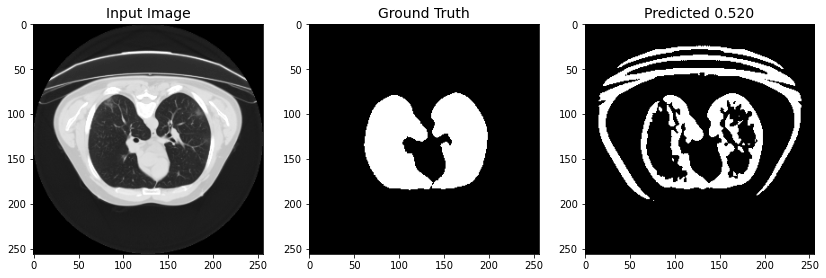

	Batch  1 0.3879515528678894
	Batch  2 0.4367830157279968
	Batch  3 0.4917799234390259
	Batch  4 0.4189710319042206
	Batch  5 0.387979656457901
	Batch  6 0.3272506892681122
Validation Loss: 0.416, Accuracy: 0.442
Epoch 1 / 10
	Batch 0 loss 0.094
	Batch 1 loss 0.114
	Batch 2 loss 0.089
	Batch 3 loss 0.083
	Batch 4 loss 0.068
	Batch 5 loss 0.115
	Batch 6 loss 0.108
	Batch 7 loss 0.123
	Batch 8 loss 0.130
	Batch 9 loss 0.039
	Batch 10 loss 0.128
	Batch 11 loss 0.185
	Batch 12 loss 0.169
	Batch 13 loss 0.234
	Batch 14 loss 0.413
	Batch 15 loss 0.200
	Batch 16 loss 0.151
	Batch 17 loss 0.128
	Batch 18 loss 0.274
	Batch 19 loss 0.180
	Batch 20 loss 0.096
	Batch 21 loss 0.113
	Batch 22 loss 0.145
	Batch 23 loss 0.219
	Batch 24 loss 0.147
	Batch 25 loss 0.188
	Batch 26 loss 0.117
	Batch 27 loss 0.122
	Batch 28 loss 0.193
	Batch 29 loss 0.146
	Batch 30 loss 0.105
	Batch 31 loss 0.084
	Batch 32 loss 0.182
	Batch 33 loss 0.137
	Batch 34 loss 0.070
	Batch 35 loss 0.076
	Batch 36 loss 0.094
	Batch 

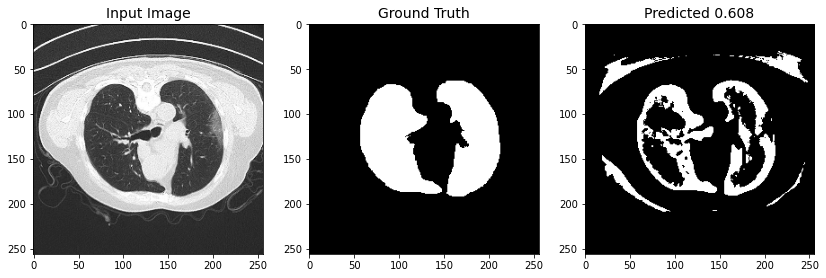

	Batch  1 0.1826295703649521
	Batch  2 0.22589027881622314
	Batch  3 0.18869221210479736
	Batch  4 0.2500809133052826
	Batch  5 0.2628341615200043
	Batch  6 0.3192681670188904
Validation Loss: 0.229, Accuracy: 0.637
Epoch 2 / 10
	Batch 0 loss 0.036
	Batch 1 loss 0.034
	Batch 2 loss 0.059
	Batch 3 loss 0.036
	Batch 4 loss 0.045
	Batch 5 loss 0.044
	Batch 6 loss 0.038
	Batch 7 loss 0.032
	Batch 8 loss 0.043
	Batch 9 loss 0.068
	Batch 10 loss 0.051
	Batch 11 loss 0.046
	Batch 12 loss 0.042
	Batch 13 loss 0.052
	Batch 14 loss 0.044
	Batch 15 loss 0.059
	Batch 16 loss 0.054
	Batch 17 loss 0.040
	Batch 18 loss 0.067
	Batch 19 loss 0.041
	Batch 20 loss 0.048
	Batch 21 loss 0.043
	Batch 22 loss 0.035
	Batch 23 loss 0.059
	Batch 24 loss 0.056
	Batch 25 loss 0.054
	Batch 26 loss 0.062
	Batch 27 loss 0.047
	Batch 28 loss 0.038
	Batch 29 loss 0.070
	Batch 30 loss 0.060
	Batch 31 loss 0.048
	Batch 32 loss 0.041
	Batch 33 loss 0.049
	Batch 34 loss 0.038
	Batch 35 loss 0.044
	Batch 36 loss 0.041
	Bat

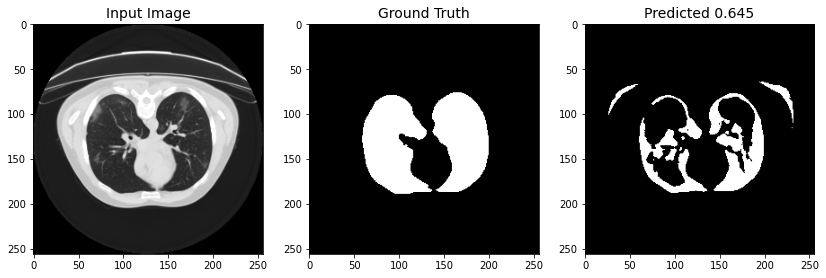

	Batch  1 0.46458303928375244
	Batch  2 0.459307998418808
	Batch  3 0.4265722632408142
	Batch  4 0.4469647705554962
	Batch  5 0.3343133330345154
	Batch  6 0.361097127199173
Validation Loss: 0.407, Accuracy: 0.581
Epoch 3 / 10
	Batch 0 loss 0.058
	Batch 1 loss 0.055
	Batch 2 loss 0.037
	Batch 3 loss 0.051
	Batch 4 loss 0.038
	Batch 5 loss 0.031
	Batch 6 loss 0.030
	Batch 7 loss 0.042
	Batch 8 loss 0.031
	Batch 9 loss 0.055
	Batch 10 loss 0.024
	Batch 11 loss 0.038
	Batch 12 loss 0.049
	Batch 13 loss 0.037
	Batch 14 loss 0.030
	Batch 15 loss 0.051
	Batch 16 loss 0.054
	Batch 17 loss 0.031
	Batch 18 loss 0.022
	Batch 19 loss 0.032
	Batch 20 loss 0.039
	Batch 21 loss 0.039
	Batch 22 loss 0.033
	Batch 23 loss 0.032
	Batch 24 loss 0.043
	Batch 25 loss 0.035
	Batch 26 loss 0.032
	Batch 27 loss 0.031
	Batch 28 loss 0.025
	Batch 29 loss 0.025
	Batch 30 loss 0.037
	Batch 31 loss 0.031
	Batch 32 loss 0.022
	Batch 33 loss 0.038
	Batch 34 loss 0.027
	Batch 35 loss 0.043
	Batch 36 loss 0.028
	Batch 

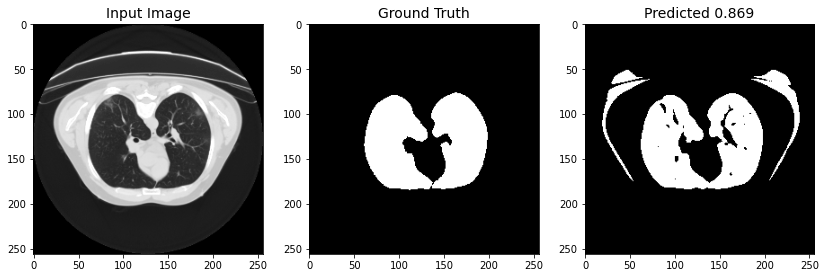

	Batch  1 0.37187790870666504
	Batch  2 0.2198910117149353
	Batch  3 0.2995442748069763
	Batch  4 0.3280126452445984
	Batch  5 0.3792037069797516
	Batch  6 0.292341023683548
Validation Loss: 0.310, Accuracy: 0.760
Epoch 4 / 10
	Batch 0 loss 0.023
	Batch 1 loss 0.024
	Batch 2 loss 0.023
	Batch 3 loss 0.043
	Batch 4 loss 0.019
	Batch 5 loss 0.025
	Batch 6 loss 0.026
	Batch 7 loss 0.022
	Batch 8 loss 0.034
	Batch 9 loss 0.041
	Batch 10 loss 0.033
	Batch 11 loss 0.024
	Batch 12 loss 0.027
	Batch 13 loss 0.025
	Batch 14 loss 0.032
	Batch 15 loss 0.030
	Batch 16 loss 0.023
	Batch 17 loss 0.025
	Batch 18 loss 0.025
	Batch 19 loss 0.024
	Batch 20 loss 0.017
	Batch 21 loss 0.040
	Batch 22 loss 0.023
	Batch 23 loss 0.029
	Batch 24 loss 0.024
	Batch 25 loss 0.032
	Batch 26 loss 0.025
	Batch 27 loss 0.037
	Batch 28 loss 0.036
	Batch 29 loss 0.041
	Batch 30 loss 0.036
	Batch 31 loss 0.029
	Batch 32 loss 0.022
	Batch 33 loss 0.062
	Batch 34 loss 0.050
	Batch 35 loss 0.024
	Batch 36 loss 0.031
	Batch

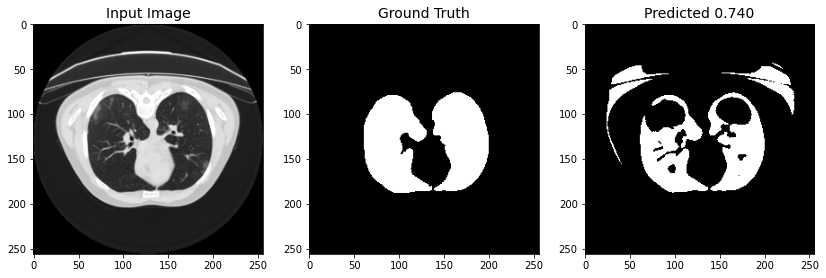

	Batch  1 0.7202463746070862
	Batch  2 0.5696921348571777
	Batch  3 0.8275855183601379
	Batch  4 1.0583792924880981
	Batch  5 0.554999589920044
	Batch  6 0.37899887561798096
Validation Loss: 0.737, Accuracy: 0.686
Epoch 5 / 10
	Batch 0 loss 0.023
	Batch 1 loss 0.037
	Batch 2 loss 0.023
	Batch 3 loss 0.017
	Batch 4 loss 0.023
	Batch 5 loss 0.030
	Batch 6 loss 0.030
	Batch 7 loss 0.026
	Batch 8 loss 0.024
	Batch 9 loss 0.017
	Batch 10 loss 0.042
	Batch 11 loss 0.032
	Batch 12 loss 0.038
	Batch 13 loss 0.026
	Batch 14 loss 0.043
	Batch 15 loss 0.020
	Batch 16 loss 0.031
	Batch 17 loss 0.050
	Batch 18 loss 0.021
	Batch 19 loss 0.023
	Batch 20 loss 0.025
	Batch 21 loss 0.038
	Batch 22 loss 0.037
	Batch 23 loss 0.031
	Batch 24 loss 0.019
	Batch 25 loss 0.044
	Batch 26 loss 0.019
	Batch 27 loss 0.026
	Batch 28 loss 0.023
	Batch 29 loss 0.022
	Batch 30 loss 0.024
	Batch 31 loss 0.022
	Batch 32 loss 0.029
	Batch 33 loss 0.030
	Batch 34 loss 0.019
	Batch 35 loss 0.032
	Batch 36 loss 0.028
	Batch

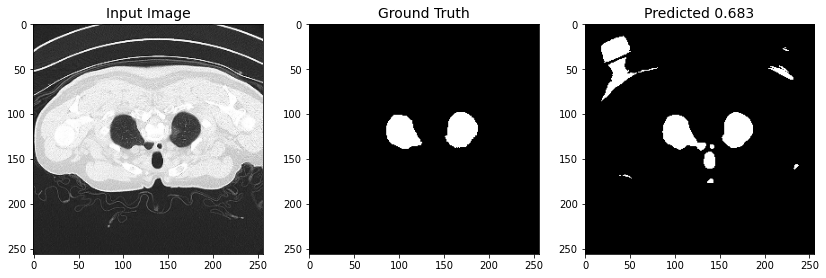

	Batch  1 0.32676762342453003
	Batch  2 0.4919132888317108
	Batch  3 0.3331262469291687
	Batch  4 0.3057522773742676
	Batch  5 0.5673022866249084
	Batch  6 0.626884937286377
Validation Loss: 0.399, Accuracy: 0.801
Epoch 6 / 10
	Batch 0 loss 0.018
	Batch 1 loss 0.030
	Batch 2 loss 0.034
	Batch 3 loss 0.020
	Batch 4 loss 0.017
	Batch 5 loss 0.020
	Batch 6 loss 0.021
	Batch 7 loss 0.019
	Batch 8 loss 0.016
	Batch 9 loss 0.017
	Batch 10 loss 0.015
	Batch 11 loss 0.024
	Batch 12 loss 0.021
	Batch 13 loss 0.027
	Batch 14 loss 0.019
	Batch 15 loss 0.015
	Batch 16 loss 0.029
	Batch 17 loss 0.022
	Batch 18 loss 0.023
	Batch 19 loss 0.015
	Batch 20 loss 0.020
	Batch 21 loss 0.025
	Batch 22 loss 0.023
	Batch 23 loss 0.024
	Batch 24 loss 0.021
	Batch 25 loss 0.027
	Batch 26 loss 0.031
	Batch 27 loss 0.023
	Batch 28 loss 0.024
	Batch 29 loss 0.026
	Batch 30 loss 0.027
	Batch 31 loss 0.032
	Batch 32 loss 0.032
	Batch 33 loss 0.022
	Batch 34 loss 0.030
	Batch 35 loss 0.025
	Batch 36 loss 0.028
	Batch

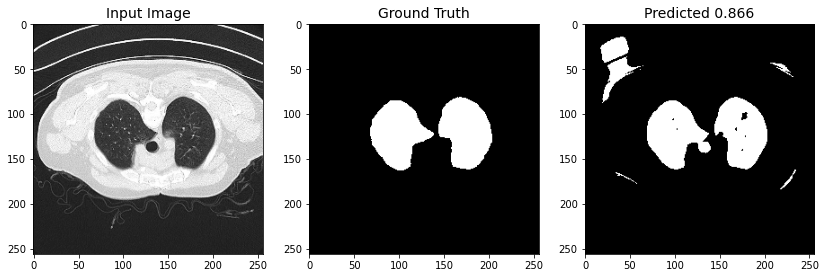

	Batch  1 0.27413350343704224
	Batch  2 0.1777624636888504
	Batch  3 0.21119384467601776
	Batch  4 0.19440877437591553
	Batch  5 0.27632105350494385
	Batch  6 0.21431167423725128
Validation Loss: 0.226, Accuracy: 0.818
Epoch 7 / 10
	Batch 0 loss 0.028
	Batch 1 loss 0.019
	Batch 2 loss 0.016
	Batch 3 loss 0.027
	Batch 4 loss 0.023
	Batch 5 loss 0.026
	Batch 6 loss 0.025
	Batch 7 loss 0.017
	Batch 8 loss 0.024
	Batch 9 loss 0.020
	Batch 10 loss 0.017
	Batch 11 loss 0.024
	Batch 12 loss 0.013
	Batch 13 loss 0.021
	Batch 14 loss 0.018
	Batch 15 loss 0.018
	Batch 16 loss 0.014
	Batch 17 loss 0.018
	Batch 18 loss 0.020
	Batch 19 loss 0.017
	Batch 20 loss 0.024
	Batch 21 loss 0.027
	Batch 22 loss 0.024
	Batch 23 loss 0.018
	Batch 24 loss 0.023
	Batch 25 loss 0.018
	Batch 26 loss 0.012
	Batch 27 loss 0.025
	Batch 28 loss 0.020
	Batch 29 loss 0.018
	Batch 30 loss 0.026
	Batch 31 loss 0.018
	Batch 32 loss 0.029
	Batch 33 loss 0.022
	Batch 34 loss 0.031
	Batch 35 loss 0.022
	Batch 36 loss 0.019
	

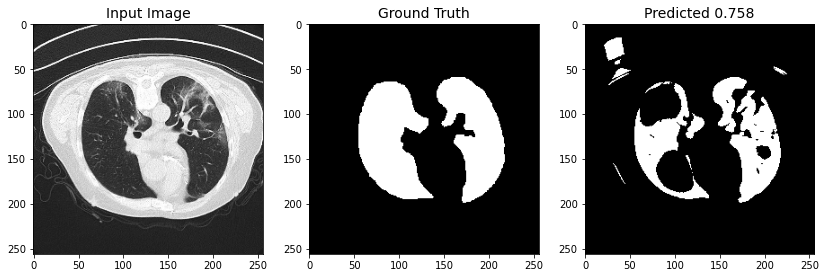

	Batch  1 3.758735418319702
	Batch  2 6.208270072937012
	Batch  3 4.065959453582764
	Batch  4 3.1551673412323
	Batch  5 3.0118322372436523
	Batch  6 3.316093683242798
Validation Loss: 3.919, Accuracy: 0.642
Epoch 8 / 10
	Batch 0 loss 0.015
	Batch 1 loss 0.073
	Batch 2 loss 0.031
	Batch 3 loss 0.103
	Batch 4 loss 0.052
	Batch 5 loss 0.063
	Batch 6 loss 0.070
	Batch 7 loss 0.091
	Batch 8 loss 0.077
	Batch 9 loss 0.028
	Batch 10 loss 0.141
	Batch 11 loss 0.036
	Batch 12 loss 0.056
	Batch 13 loss 0.066
	Batch 14 loss 0.097
	Batch 15 loss 0.337
	Batch 16 loss 0.092
	Batch 17 loss 0.056
	Batch 18 loss 0.144
	Batch 19 loss 0.122
	Batch 20 loss 0.077
	Batch 21 loss 0.054
	Batch 22 loss 0.037
	Batch 23 loss 0.064
	Batch 24 loss 0.090
	Batch 25 loss 0.068
	Batch 26 loss 0.029
	Batch 27 loss 0.031
	Batch 28 loss 0.036
	Batch 29 loss 0.034
	Batch 30 loss 0.056
	Batch 31 loss 0.031
	Batch 32 loss 0.034
	Batch 33 loss 0.018
	Batch 34 loss 0.033
	Batch 35 loss 0.021
	Batch 36 loss 0.088
	Batch 37 los

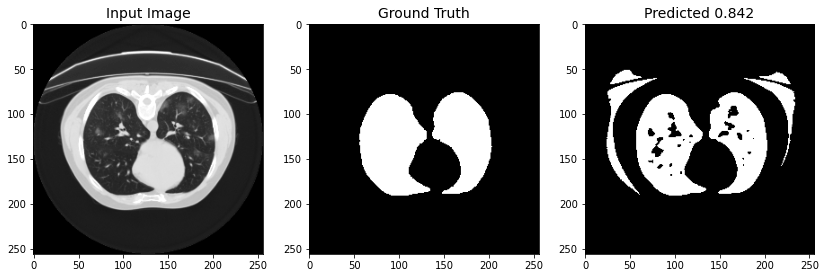

	Batch  1 0.29180365800857544
	Batch  2 0.23877909779548645
	Batch  3 0.24335962533950806
	Batch  4 0.2553543448448181
	Batch  5 0.24719300866127014
	Batch  6 0.3166353702545166
Validation Loss: 0.267, Accuracy: 0.787
Epoch 9 / 10
	Batch 0 loss 0.021
	Batch 1 loss 0.024
	Batch 2 loss 0.023
	Batch 3 loss 0.018
	Batch 4 loss 0.046
	Batch 5 loss 0.027
	Batch 6 loss 0.025
	Batch 7 loss 0.023
	Batch 8 loss 0.024
	Batch 9 loss 0.029
	Batch 10 loss 0.035
	Batch 11 loss 0.030
	Batch 12 loss 0.023
	Batch 13 loss 0.021
	Batch 14 loss 0.044
	Batch 15 loss 0.035
	Batch 16 loss 0.028
	Batch 17 loss 0.018
	Batch 18 loss 0.026
	Batch 19 loss 0.039
	Batch 20 loss 0.017
	Batch 21 loss 0.030
	Batch 22 loss 0.030
	Batch 23 loss 0.018
	Batch 24 loss 0.023
	Batch 25 loss 0.040
	Batch 26 loss 0.014
	Batch 27 loss 0.041
	Batch 28 loss 0.019
	Batch 29 loss 0.031
	Batch 30 loss 0.018
	Batch 31 loss 0.031
	Batch 32 loss 0.025
	Batch 33 loss 0.035
	Batch 34 loss 0.023
	Batch 35 loss 0.016
	Batch 36 loss 0.016
	B

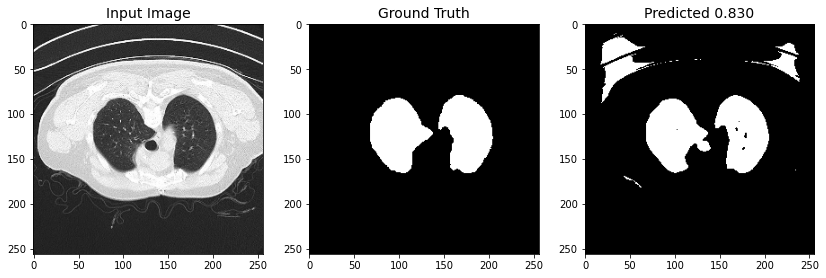

	Batch  1 0.27577927708625793
	Batch  2 0.35707199573516846
	Batch  3 0.23894737660884857
	Batch  4 0.25084173679351807
	Batch  5 0.30936291813850403
	Batch  6 0.2717382311820984
Validation Loss: 0.278, Accuracy: 0.809


In [ ]:
train_accuracy = []
train_loss = []

validation_accuracy = []
validation_loss = []

for epoch in range(epochs):
 
    #
    # Training Loop
    #

    print('='*30)
    print('Epoch {} / {}'.format(epoch, epochs))
    
    # Set variables
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_counter = 0
    
    model.train()

    # Batch Training Loop (Loop over the batches)
    for index, (X, Y) in enumerate(train_Lung_dataloader):
        
        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)

        # Compute the loss
        L = loss(R, Y.long())

        # Do PyTorch stuff - Training 
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        
        pred = R.data.max(1)[1]
        
        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_loss += L.data.item() * X.shape[0]
        print(f'\tBatch {index} loss {L.data.item():3.3f}')
        
        epoch_counter += X.shape[0]
  
    # Epoch Train Loss
    train_accuracy.append(epoch_accuracy/epoch_counter)
    train_loss.append(epoch_loss/epoch_counter)
    print(f"Loss: {train_loss[-1]:3.3f}, Accuracy: {train_accuracy[-1]:3.3f}")
    
    #
    # Validation Loop 
    #
   
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_counter = 0
    
    model.eval()
    
    # Batch Validation Loop (Loop over the batches)
    with torch.no_grad():
        for index, (X, Y) in enumerate(val_Lung_dataloader):

            if device is not None:
                X = X.to(device)
                Y = Y.to(device)

            # Call the model (image to mask)
            R = model(X)

            # Compute the loss
            L = loss(R, Y.long())

            pred = R.data.max(1)[1]

            # Analyze the accuracy of the batch 
            epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
            epoch_loss += L.data.item() * X.shape[0]
            print('\tBatch ', index, L.data.item())

            if index == 0:
                plt.figure(figsize=[14, 7])
                plt.subplot(1,3,1)
                plt.imshow(X[0, 0].cpu().detach().numpy())
                plt.title('Input Image', fontsize=14)
                plt.subplot(1,3,2)
                plt.imshow(Y[0].cpu().detach().numpy())
                plt.title('Ground Truth', fontsize=14)
                plt.subplot(1,3,3)
                plt.imshow(pred[0].cpu().detach().numpy())
                plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
                plt.show()

            epoch_counter += X.shape[0]

    # Epoch Train Loss
    validation_accuracy.append(epoch_accuracy/epoch_counter)
    validation_loss.append(epoch_loss/epoch_counter)
    print(f"Validation Loss: {validation_loss[-1]:3.3f}, Accuracy: {validation_accuracy[-1]:3.3f}")
    

# Plot Loss and Accuracy Curves (Lung Mask)



In [ ]:
# Display Train and Validation Loss and Dice scores

fig = plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Training')
plt.plot(validation_loss, label='Validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.xticks(range(epochs))
plt.grid('on')
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.xticks(range(epochs))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Dice', fontsize=14)
plt.title('Training and Validation Dice-Score', fontsize=16)
plt.grid('on')

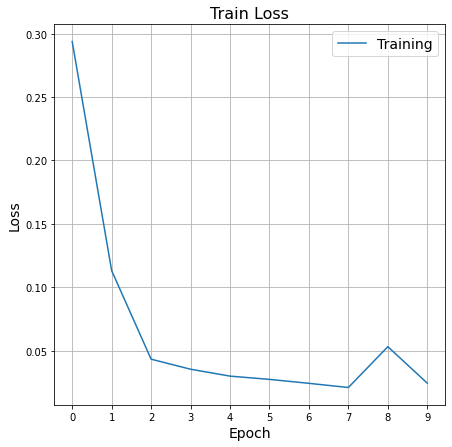

In [ ]:
fig = plt.figure(figsize=(7, 7))
plt.plot(train_loss, label='Training')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss', fontsize=16)
plt.xticks(range(epochs))
plt.grid('on')
plt.legend(fontsize=14)

# Run Neural Network on Test Data (Lung Mask)

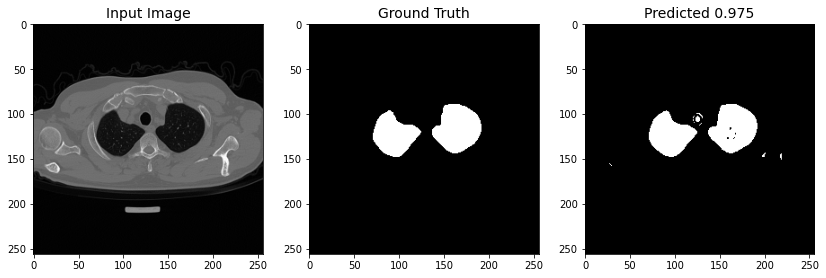

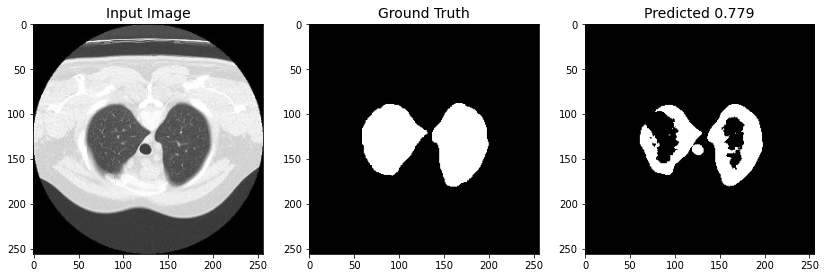

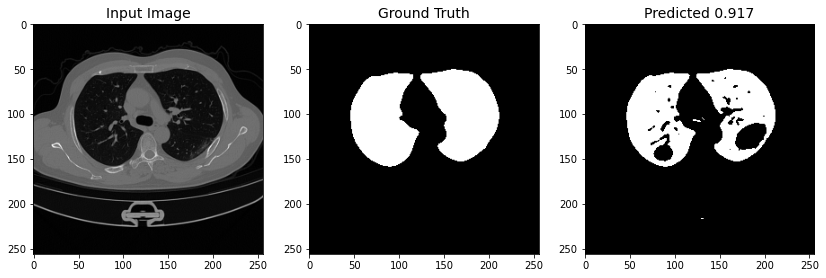

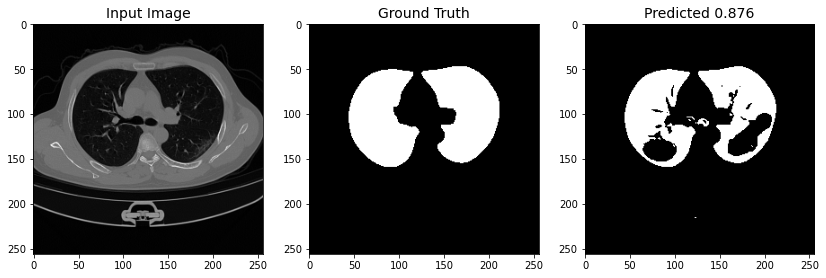

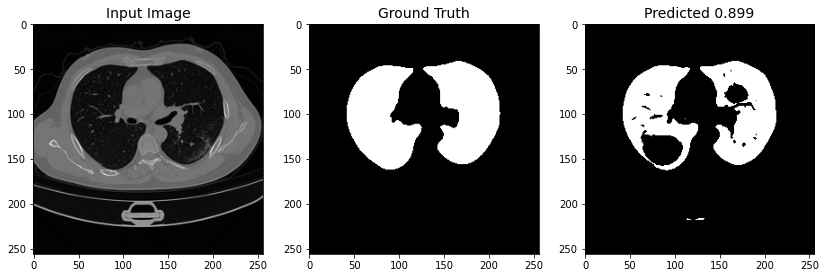

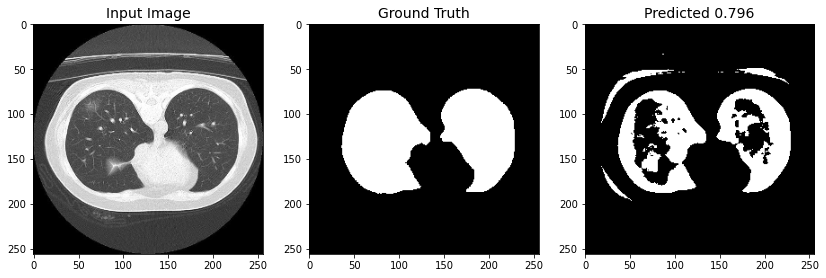

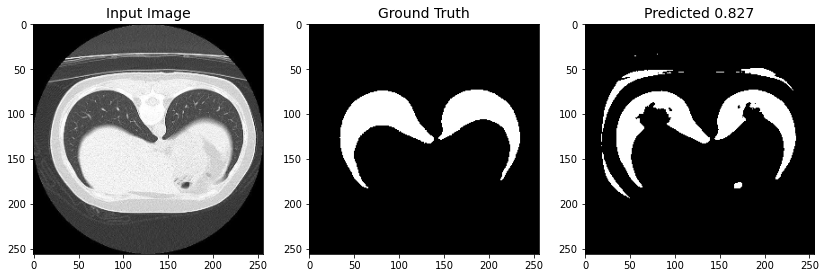

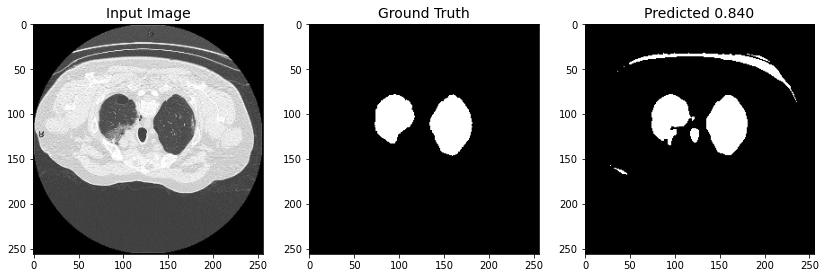

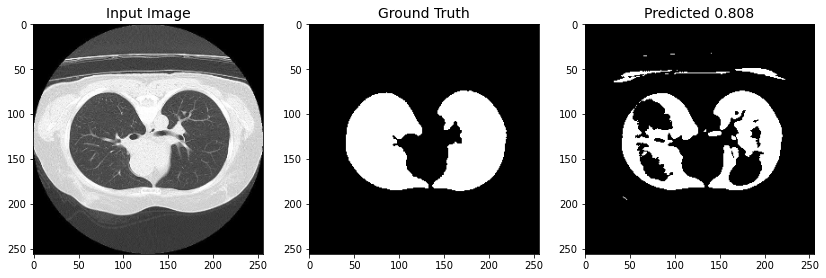

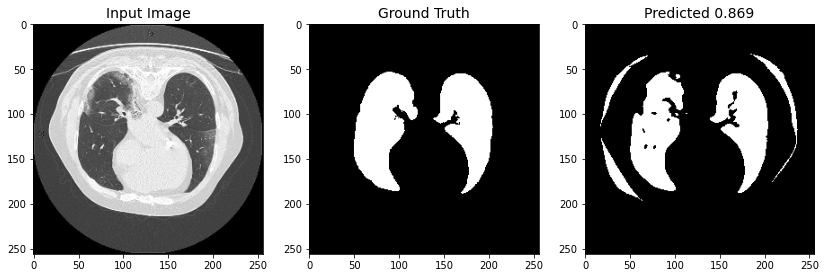

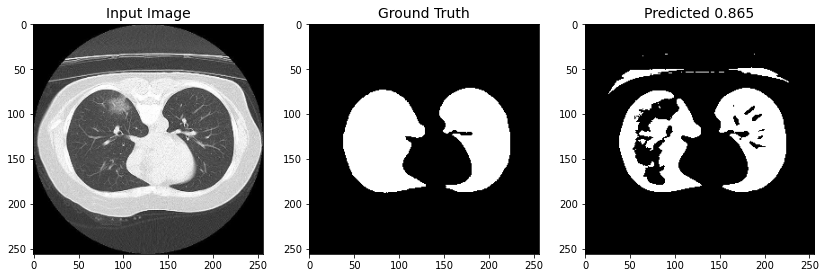

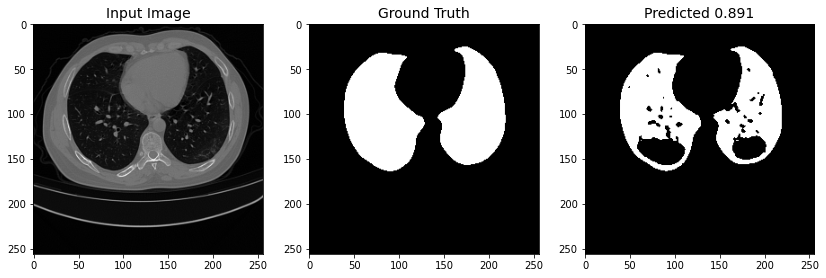

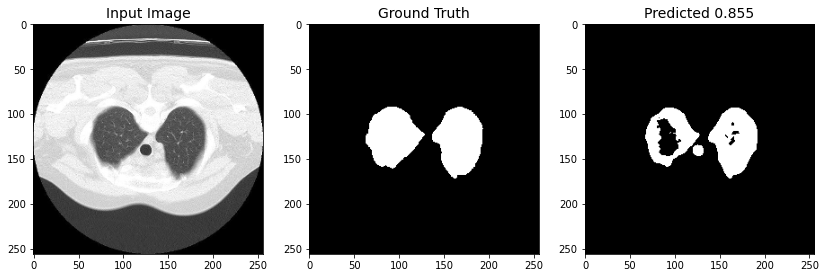

Test Accuracy: 0.885


In [ ]:
model.eval()

test_accuracy = []
test_loss = []
epoch_accuracy = 0
epoch_counter = 0

model.eval()

with torch.no_grad():
    # Batch Validation Loop (Loop over the batches)
    for index, (X, Y) in enumerate(test_Lung_dataloader):

        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)

        pred = R.data.max(1)[1]

        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_counter += X.shape[0]

        #
        # Display the first image, mask and predicted of the batch
        #
        plt.figure(figsize=[14, 7])
        plt.title('Lung Segmentation using Neural Network')
        plt.subplot(1,3,1)
        plt.imshow(X[0, 0].cpu().detach().numpy())
        plt.title('Input Image', fontsize=14)
        plt.subplot(1,3,2)
        plt.imshow(Y[0].cpu().detach().numpy())
        plt.title('Ground Truth', fontsize=14)
        plt.subplot(1,3,3)
        plt.imshow(pred[0].cpu().detach().numpy())
        plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
        plt.show()
        
    # Epoch Train Loss
    test_accuracy.append(epoch_accuracy/epoch_counter)
    test_loss.append(epoch_loss/epoch_counter)
    print(f"Test Accuracy: {test_accuracy[-1]:3.3f}")

# Train the Neural Network (Infection Mask)

In [ ]:
#
# Load the model
#

model_infection = unet()
model_infection.to(device)

#
# Create the optimizer
#
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#
# Create the loss function
#
loss = torch.nn.CrossEntropyLoss()

# Training (Infection Mask)

Epoch 0 / 10
	Batch 0 loss 0.867
	Batch 1 loss 0.971
	Batch 2 loss 0.867
	Batch 3 loss 0.920
	Batch 4 loss 0.991
	Batch 5 loss 0.863
	Batch 6 loss 0.950
	Batch 7 loss 0.919
	Batch 8 loss 1.117
	Batch 9 loss 0.885
	Batch 10 loss 0.925
	Batch 11 loss 0.861
	Batch 12 loss 0.915
	Batch 13 loss 0.914
	Batch 14 loss 0.923
	Batch 15 loss 0.974
	Batch 16 loss 1.007
	Batch 17 loss 0.985
	Batch 18 loss 0.912
	Batch 19 loss 1.102
	Batch 20 loss 0.867
	Batch 21 loss 0.942
	Batch 22 loss 0.984
	Batch 23 loss 0.927
	Batch 24 loss 0.883
	Batch 25 loss 0.873
	Batch 26 loss 0.940
	Batch 27 loss 1.035
	Batch 28 loss 1.135
	Batch 29 loss 0.877
	Batch 30 loss 0.961
	Batch 31 loss 0.923
	Batch 32 loss 1.202
	Batch 33 loss 0.921
	Batch 34 loss 0.973
	Batch 35 loss 1.099
	Batch 36 loss 1.072
	Batch 37 loss 0.933
	Batch 38 loss 1.072
	Batch 39 loss 0.908
	Batch 40 loss 0.959
	Batch 41 loss 0.875
	Batch 42 loss 0.865
	Batch 43 loss 0.923
	Batch 44 loss 1.022
	Batch 45 loss 1.136
	Batch 46 loss 0.983
	Batch 47 

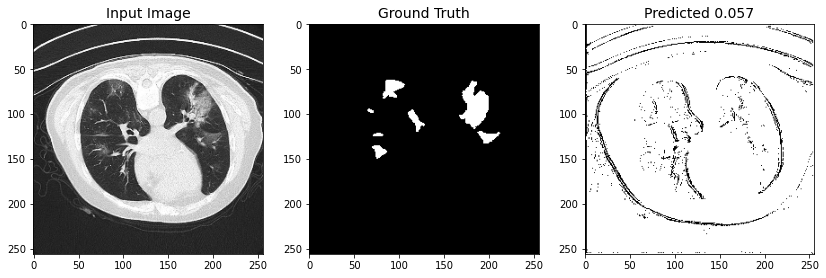

	Batch  1 1.2166160345077515
	Batch  2 1.2808880805969238
	Batch  3 1.2135900259017944
	Batch  4 1.2779545783996582
	Batch  5 1.1607836484909058
	Batch  6 1.0797277688980103
Validation Loss: 1.223, Accuracy: 0.018
Epoch 1 / 10
	Batch 0 loss 0.999
	Batch 1 loss 0.883
	Batch 2 loss 0.909
	Batch 3 loss 1.009
	Batch 4 loss 1.067
	Batch 5 loss 0.967
	Batch 6 loss 1.064
	Batch 7 loss 0.999
	Batch 8 loss 0.966
	Batch 9 loss 0.890
	Batch 10 loss 0.915
	Batch 11 loss 0.870
	Batch 12 loss 1.068
	Batch 13 loss 0.980
	Batch 14 loss 1.037
	Batch 15 loss 0.918
	Batch 16 loss 1.025
	Batch 17 loss 1.045
	Batch 18 loss 0.910
	Batch 19 loss 1.033
	Batch 20 loss 1.082
	Batch 21 loss 0.948
	Batch 22 loss 0.928
	Batch 23 loss 0.921
	Batch 24 loss 0.989
	Batch 25 loss 1.007
	Batch 26 loss 0.942
	Batch 27 loss 0.953
	Batch 28 loss 0.926
	Batch 29 loss 0.961
	Batch 30 loss 0.911
	Batch 31 loss 0.962
	Batch 32 loss 1.075
	Batch 33 loss 1.043
	Batch 34 loss 0.922
	Batch 35 loss 0.966
	Batch 36 loss 1.079
	Batch

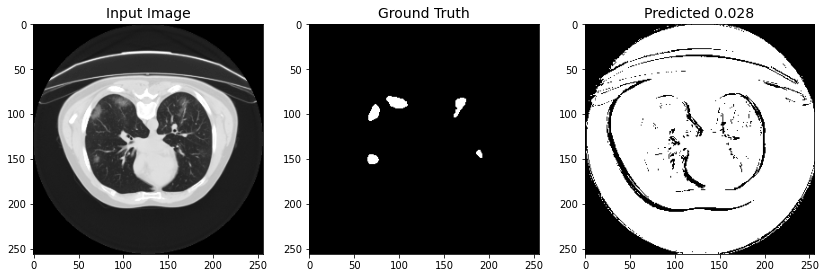

	Batch  1 1.1821784973144531
	Batch  2 1.2060269117355347
	Batch  3 1.2643709182739258
	Batch  4 1.2369824647903442
	Batch  5 1.2437715530395508
	Batch  6 1.1912306547164917
Validation Loss: 1.223, Accuracy: 0.018
Epoch 2 / 10
	Batch 0 loss 1.010
	Batch 1 loss 0.925
	Batch 2 loss 0.866
	Batch 3 loss 0.949
	Batch 4 loss 1.022
	Batch 5 loss 0.876
	Batch 6 loss 0.961
	Batch 7 loss 0.913
	Batch 8 loss 1.059
	Batch 9 loss 0.916
	Batch 10 loss 1.001
	Batch 11 loss 0.896
	Batch 12 loss 0.991
	Batch 13 loss 0.931
	Batch 14 loss 0.973
	Batch 15 loss 0.993
	Batch 16 loss 0.915
	Batch 17 loss 0.992
	Batch 18 loss 0.988
	Batch 19 loss 0.935
	Batch 20 loss 0.922
	Batch 21 loss 1.082
	Batch 22 loss 1.050
	Batch 23 loss 0.924
	Batch 24 loss 0.930
	Batch 25 loss 0.981
	Batch 26 loss 0.943
	Batch 27 loss 0.882
	Batch 28 loss 0.926
	Batch 29 loss 1.021
	Batch 30 loss 1.001
	Batch 31 loss 0.859
	Batch 32 loss 0.861
	Batch 33 loss 1.187
	Batch 34 loss 0.995
	Batch 35 loss 1.192
	Batch 36 loss 1.041
	Batch

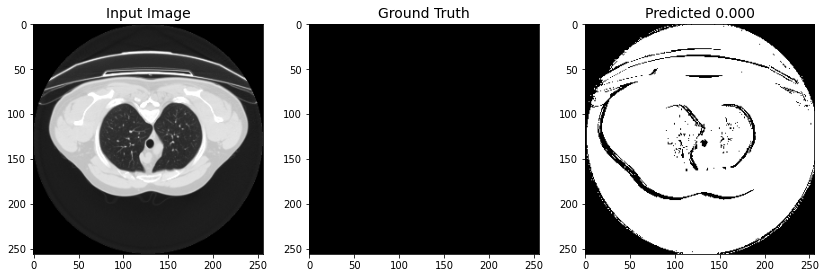

	Batch  1 1.3043988943099976
	Batch  2 1.228408694267273
	Batch  3 1.121061086654663
	Batch  4 1.235359787940979
	Batch  5 1.2678358554840088
	Batch  6 1.1903377771377563
Validation Loss: 1.223, Accuracy: 0.018
Epoch 3 / 10
	Batch 0 loss 0.864
	Batch 1 loss 0.924
	Batch 2 loss 1.064
	Batch 3 loss 0.868
	Batch 4 loss 0.981
	Batch 5 loss 0.983
	Batch 6 loss 0.990
	Batch 7 loss 0.972
	Batch 8 loss 0.980
	Batch 9 loss 0.874
	Batch 10 loss 1.020
	Batch 11 loss 0.908
	Batch 12 loss 1.013
	Batch 13 loss 0.919
	Batch 14 loss 0.895
	Batch 15 loss 0.898
	Batch 16 loss 0.888
	Batch 17 loss 1.047
	Batch 18 loss 1.050
	Batch 19 loss 1.025
	Batch 20 loss 1.005
	Batch 21 loss 0.967
	Batch 22 loss 0.946
	Batch 23 loss 1.003
	Batch 24 loss 0.917
	Batch 25 loss 0.965
	Batch 26 loss 0.934
	Batch 27 loss 1.025
	Batch 28 loss 0.863
	Batch 29 loss 0.958
	Batch 30 loss 0.877
	Batch 31 loss 1.046
	Batch 32 loss 0.999
	Batch 33 loss 0.917
	Batch 34 loss 1.054
	Batch 35 loss 1.147
	Batch 36 loss 0.880
	Batch 37

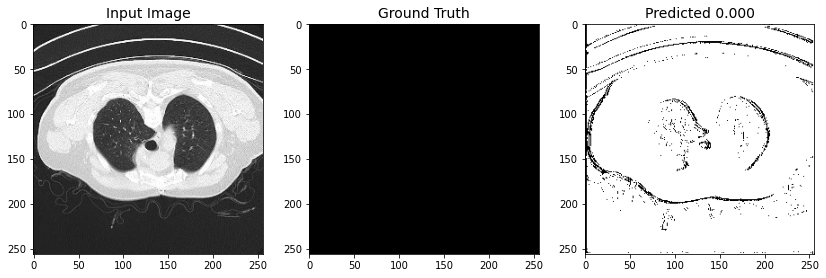

	Batch  1 1.1392395496368408
	Batch  2 1.2303566932678223
	Batch  3 1.2931268215179443
	Batch  4 1.2662402391433716
	Batch  5 1.1802104711532593
	Batch  6 1.3167526721954346
Validation Loss: 1.223, Accuracy: 0.017
Epoch 4 / 10
	Batch 0 loss 0.870
	Batch 1 loss 0.910
	Batch 2 loss 0.967
	Batch 3 loss 1.069
	Batch 4 loss 0.899
	Batch 5 loss 0.944
	Batch 6 loss 1.020
	Batch 7 loss 1.039
	Batch 8 loss 1.121
	Batch 9 loss 0.993
	Batch 10 loss 0.956
	Batch 11 loss 0.864
	Batch 12 loss 1.020
	Batch 13 loss 0.924
	Batch 14 loss 0.987
	Batch 15 loss 0.968
	Batch 16 loss 0.978
	Batch 17 loss 0.971
	Batch 18 loss 1.014
	Batch 19 loss 1.032
	Batch 20 loss 0.954
	Batch 21 loss 0.994
	Batch 22 loss 0.918
	Batch 23 loss 0.919
	Batch 24 loss 0.916
	Batch 25 loss 0.994
	Batch 26 loss 0.933
	Batch 27 loss 0.846
	Batch 28 loss 1.017
	Batch 29 loss 0.896
	Batch 30 loss 1.066
	Batch 31 loss 0.941
	Batch 32 loss 1.104
	Batch 33 loss 0.988
	Batch 34 loss 0.977
	Batch 35 loss 0.948
	Batch 36 loss 1.027
	Batch

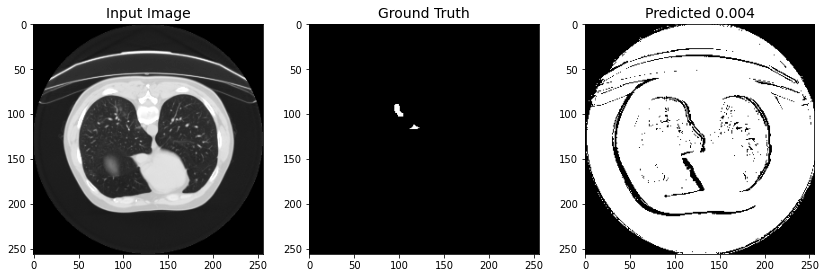

	Batch  1 1.2212700843811035
	Batch  2 1.1553854942321777
	Batch  3 1.231016755104065
	Batch  4 1.2610549926757812
	Batch  5 1.2787278890609741
	Batch  6 1.218719482421875
Validation Loss: 1.223, Accuracy: 0.018
Epoch 5 / 10
	Batch 0 loss 1.028
	Batch 1 loss 1.006
	Batch 2 loss 0.914
	Batch 3 loss 1.182
	Batch 4 loss 1.100
	Batch 5 loss 0.871
	Batch 6 loss 1.034
	Batch 7 loss 0.925
	Batch 8 loss 0.932
	Batch 9 loss 0.955
	Batch 10 loss 0.983
	Batch 11 loss 1.009
	Batch 12 loss 0.920
	Batch 13 loss 0.945
	Batch 14 loss 0.940
	Batch 15 loss 0.924
	Batch 16 loss 0.932
	Batch 17 loss 0.922
	Batch 18 loss 1.007
	Batch 19 loss 0.869
	Batch 20 loss 0.857
	Batch 21 loss 0.989
	Batch 22 loss 1.143
	Batch 23 loss 0.921
	Batch 24 loss 0.957
	Batch 25 loss 0.939
	Batch 26 loss 0.871
	Batch 27 loss 0.996
	Batch 28 loss 0.958
	Batch 29 loss 0.917
	Batch 30 loss 1.031
	Batch 31 loss 1.031
	Batch 32 loss 0.894
	Batch 33 loss 0.993
	Batch 34 loss 0.974
	Batch 35 loss 0.912
	Batch 36 loss 0.994
	Batch 3

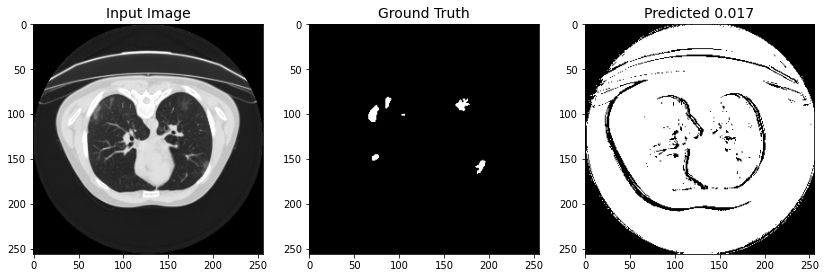

	Batch  1 1.2375893592834473
	Batch  2 1.1924346685409546
	Batch  3 1.2589340209960938
	Batch  4 1.1428602933883667
	Batch  5 1.3039666414260864
	Batch  6 1.4182995557785034
Validation Loss: 1.223, Accuracy: 0.018
Epoch 6 / 10
	Batch 0 loss 0.960
	Batch 1 loss 1.057
	Batch 2 loss 0.870
	Batch 3 loss 0.918
	Batch 4 loss 0.987
	Batch 5 loss 0.987
	Batch 6 loss 0.871
	Batch 7 loss 0.970
	Batch 8 loss 0.963
	Batch 9 loss 0.875
	Batch 10 loss 1.069
	Batch 11 loss 1.053
	Batch 12 loss 0.968
	Batch 13 loss 0.982
	Batch 14 loss 1.001
	Batch 15 loss 0.998
	Batch 16 loss 1.055
	Batch 17 loss 0.993
	Batch 18 loss 0.925
	Batch 19 loss 0.926
	Batch 20 loss 1.173
	Batch 21 loss 1.022
	Batch 22 loss 0.975
	Batch 23 loss 0.952
	Batch 24 loss 1.016
	Batch 25 loss 0.976
	Batch 26 loss 1.117
	Batch 27 loss 0.907
	Batch 28 loss 0.961
	Batch 29 loss 0.990
	Batch 30 loss 0.994
	Batch 31 loss 0.965
	Batch 32 loss 0.876
	Batch 33 loss 1.061
	Batch 34 loss 0.883
	Batch 35 loss 0.986
	Batch 36 loss 0.973
	Batch

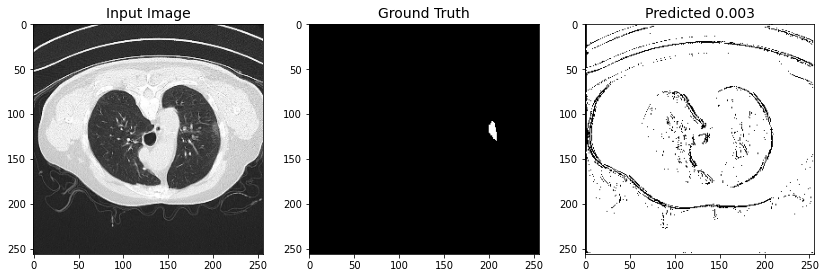

	Batch  1 1.203199863433838
	Batch  2 1.1649888753890991
	Batch  3 1.2575112581253052
	Batch  4 1.3253273963928223
	Batch  5 1.1484469175338745
	Batch  6 1.3071644306182861
Validation Loss: 1.223, Accuracy: 0.017
Epoch 7 / 10
	Batch 0 loss 1.051
	Batch 1 loss 1.003
	Batch 2 loss 0.830
	Batch 3 loss 1.048
	Batch 4 loss 0.940
	Batch 5 loss 0.982
	Batch 6 loss 1.075
	Batch 7 loss 0.858
	Batch 8 loss 0.854
	Batch 9 loss 0.892
	Batch 10 loss 0.930
	Batch 11 loss 0.881
	Batch 12 loss 0.886
	Batch 13 loss 0.871
	Batch 14 loss 1.022
	Batch 15 loss 1.144
	Batch 16 loss 1.027
	Batch 17 loss 0.931
	Batch 18 loss 0.923
	Batch 19 loss 1.037
	Batch 20 loss 0.934
	Batch 21 loss 0.984
	Batch 22 loss 0.938
	Batch 23 loss 1.037
	Batch 24 loss 1.085
	Batch 25 loss 1.076
	Batch 26 loss 0.973
	Batch 27 loss 0.915
	Batch 28 loss 0.900
	Batch 29 loss 0.955
	Batch 30 loss 0.873
	Batch 31 loss 0.871
	Batch 32 loss 0.904
	Batch 33 loss 0.993
	Batch 34 loss 0.961
	Batch 35 loss 0.966
	Batch 36 loss 0.920
	Batch 

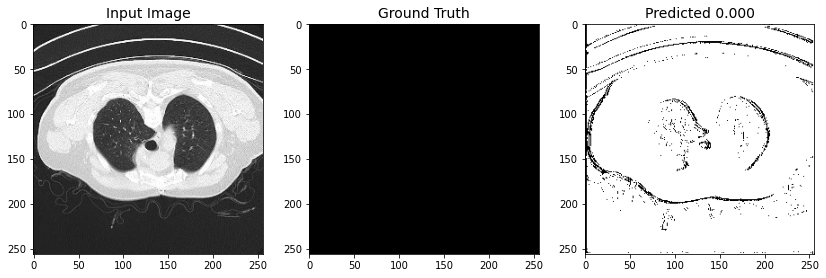

	Batch  1 1.1731626987457275
	Batch  2 1.2238740921020508
	Batch  3 1.2324059009552002
	Batch  4 1.2404892444610596
	Batch  5 1.2626770734786987
	Batch  6 1.092703104019165
Validation Loss: 1.223, Accuracy: 0.018
Epoch 8 / 10
	Batch 0 loss 1.062
	Batch 1 loss 1.066
	Batch 2 loss 0.924
	Batch 3 loss 0.933
	Batch 4 loss 1.165
	Batch 5 loss 0.974
	Batch 6 loss 1.151
	Batch 7 loss 0.953
	Batch 8 loss 0.989
	Batch 9 loss 0.924
	Batch 10 loss 1.015
	Batch 11 loss 0.929
	Batch 12 loss 0.963
	Batch 13 loss 0.973
	Batch 14 loss 0.888
	Batch 15 loss 1.041
	Batch 16 loss 1.042
	Batch 17 loss 0.975
	Batch 18 loss 0.915
	Batch 19 loss 1.058
	Batch 20 loss 1.036
	Batch 21 loss 0.934
	Batch 22 loss 0.975
	Batch 23 loss 0.925
	Batch 24 loss 0.924
	Batch 25 loss 0.875
	Batch 26 loss 0.846
	Batch 27 loss 0.944
	Batch 28 loss 0.979
	Batch 29 loss 0.940
	Batch 30 loss 1.051
	Batch 31 loss 1.040
	Batch 32 loss 0.870
	Batch 33 loss 0.964
	Batch 34 loss 0.876
	Batch 35 loss 1.017
	Batch 36 loss 0.927
	Batch 

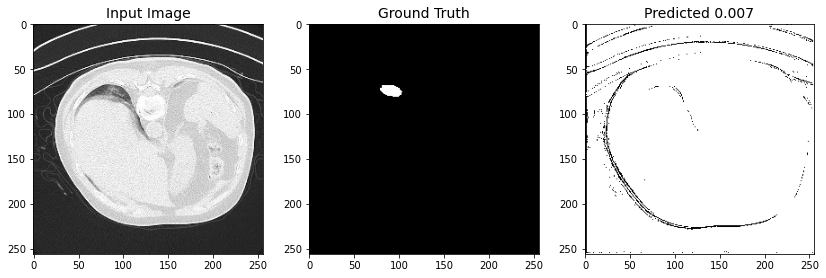

	Batch  1 1.252585530281067
	Batch  2 1.2775802612304688
	Batch  3 1.1327428817749023
	Batch  4 1.223345160484314
	Batch  5 1.230893611907959
	Batch  6 1.1875598430633545
Validation Loss: 1.223, Accuracy: 0.018
Epoch 9 / 10
	Batch 0 loss 0.931
	Batch 1 loss 1.001
	Batch 2 loss 1.092
	Batch 3 loss 0.979
	Batch 4 loss 0.921
	Batch 5 loss 0.884
	Batch 6 loss 1.042
	Batch 7 loss 0.948
	Batch 8 loss 0.999
	Batch 9 loss 0.990
	Batch 10 loss 1.039
	Batch 11 loss 0.984
	Batch 12 loss 0.985
	Batch 13 loss 0.906
	Batch 14 loss 1.027
	Batch 15 loss 0.830
	Batch 16 loss 0.873
	Batch 17 loss 0.950
	Batch 18 loss 0.924
	Batch 19 loss 0.929
	Batch 20 loss 0.997
	Batch 21 loss 0.976
	Batch 22 loss 0.960
	Batch 23 loss 1.058
	Batch 24 loss 0.913
	Batch 25 loss 0.958
	Batch 26 loss 0.971
	Batch 27 loss 0.988
	Batch 28 loss 0.971
	Batch 29 loss 0.888
	Batch 30 loss 0.877
	Batch 31 loss 0.868
	Batch 32 loss 0.955
	Batch 33 loss 1.017
	Batch 34 loss 0.999
	Batch 35 loss 0.966
	Batch 36 loss 0.998
	Batch 37

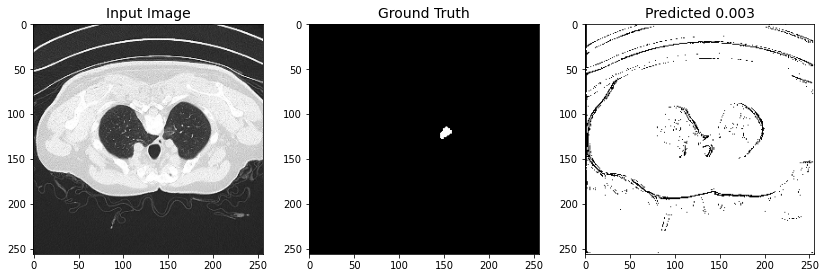

	Batch  1 1.2585580348968506
	Batch  2 1.2089605331420898
	Batch  3 1.156197428703308
	Batch  4 1.249619483947754
	Batch  5 1.1417160034179688
	Batch  6 1.4196079969406128
Validation Loss: 1.223, Accuracy: 0.018


In [ ]:
train_infection_accuracy = []
train_infection_loss = []

validation_infection_accuracy = []
validation_infection_loss = []

for epoch in range(epochs):
 
    #
    # Training Loop
    #

    print('='*30)
    print('Epoch {} / {}'.format(epoch, epochs))
    
    # Set variables
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_counter = 0
    
    model_infection.train()

    # Batch Training Loop (Loop over the batches)
    for index, (X, Y) in enumerate(train_Infection_dataloader):
        
        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model_infection(X)

        # Compute the loss
        L = loss(R, Y.long())

        # Do PyTorch stuff - Training 
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        
        pred = R.data.max(1)[1]
        
        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_loss += L.data.item() * X.shape[0]
        print(f'\tBatch {index} loss {L.data.item():3.3f}')
        
        epoch_counter += X.shape[0]
  
    # Epoch Train Loss
    train_infection_accuracy.append(epoch_accuracy/epoch_counter)
    train_infection_loss.append(epoch_loss/epoch_counter)
    print(f"Loss: {train_infection_loss[-1]:3.3f}, Accuracy: {train_infection_accuracy[-1]:3.3f}")
    
    #
    # Validation Loop 
    #
   
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_counter = 0
    
    model_infection.eval()
    
    # Batch Validation Loop (Loop over the batches)
    with torch.no_grad():
        for index, (X, Y) in enumerate(val_Infection_dataloader):

            if device is not None:
                X = X.to(device)
                Y = Y.to(device)

            # Call the model (image to mask)
            R = model_infection(X)

            # Compute the loss
            L = loss(R, Y.long())

            pred = R.data.max(1)[1]

            # Analyze the accuracy of the batch 
            epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
            epoch_loss += L.data.item() * X.shape[0]
            print('\tBatch ', index, L.data.item())

            if index == 0:
                plt.figure(figsize=[14, 7])
                plt.subplot(1,3,1)
                plt.imshow(X[0, 0].cpu().detach().numpy())
                plt.title('Input Image', fontsize=14)
                plt.subplot(1,3,2)
                plt.imshow(Y[0].cpu().detach().numpy())
                plt.title('Ground Truth', fontsize=14)
                plt.subplot(1,3,3)
                plt.imshow(pred[0].cpu().detach().numpy())
                plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
                plt.show()

            epoch_counter += X.shape[0]

    # Epoch Train Loss
    validation_infection_accuracy.append(epoch_accuracy/epoch_counter)
    validation_infection_loss.append(epoch_loss/epoch_counter)
    print(f"Validation Loss: {validation_infection_loss[-1]:3.3f}, Accuracy: {validation_infection_accuracy[-1]:3.3f}")
    

# Plot Loss and Accuracy Curves (Infection Mask)

In [ ]:
# Display Train and Validation Loss and Dice scores

fig = plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
plt.plot(train_infection_loss, label='Training')
plt.plot(validation_infection_loss, label='Validation')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Train and Validation Loss', fontsize=16)
plt.xticks(range(epochs))
plt.grid('on')
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.plot(train_infection_accuracy)
plt.plot(validation_infection_accuracy)
plt.xticks(range(epochs))
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Dice', fontsize=14)
plt.title('Train and Validation Dice-Score', fontsize=16)
plt.grid('on')

# Run Neural Network on Test Data (Lung Mask)

In [ ]:
model.eval()

test_infection_accuracy = []
test_infection_loss = []
epoch_accuracy = 0
epoch_counter = 0

model_infection.eval()

with torch.no_grad():
    # Batch Validation Loop (Loop over the batches)
    for index, (X, Y) in enumerate(test_Infection_dataloader):

        if device is not None:
            X = X.to(device)
            Y = Y.to(device)

        # Call the model (image to mask)
        R = model(X)

        pred = R.data.max(1)[1]

        # Analyze the accuracy of the batch 
        epoch_accuracy += dice_coef(pred, Y) * X.shape[0]
        epoch_counter += X.shape[0]

        #
        # Display the first image, mask and predicted of the batch
        #
        plt.figure(figsize=[14, 7])
        plt.figure.title('Lung Infection Segmentation using Neural Network')
        plt.subplot(1,3,1)
        plt.imshow(X[0, 0].cpu().detach().numpy())
        plt.title('Input Image', fontsize=14)
        plt.subplot(1,3,2)
        plt.imshow(Y[0].cpu().detach().numpy())
        plt.title('Ground Truth', fontsize=14)
        plt.subplot(1,3,3)
        plt.imshow(pred[0].cpu().detach().numpy())
        plt.title(f'Predicted {dice_coef(pred[0], Y[0]):3.3f}', fontsize=14)
        plt.show()
        
    # Epoch Train Loss
    test_infection_accuracy.append(epoch_accuracy/epoch_counter)
    test_infection_loss.append(epoch_loss/epoch_counter)
    print(f"Test Accuracy: {test_infection_accuracy[-1]:3.3f}")